In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : features,
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_RunLeng

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:59 - loss: 2.3181 - STD: 0.0772 - MAE: 0.2187

  4/395 [..............................] - ETA: 7s - loss: 2.1577 - STD: 0.0569 - MAE: 0.2169  

  7/395 [..............................] - ETA: 6s - loss: 2.1265 - STD: 0.0516 - MAE: 0.2169

 10/395 [..............................] - ETA: 6s - loss: 2.1135 - STD: 0.0500 - MAE: 0.2168

 13/395 [..............................] - ETA: 6s - loss: 2.0986 - STD: 0.0467 - MAE: 0.2167

 16/395 [>.............................] - ETA: 6s - loss: 2.0905 - STD: 0.0444 - MAE: 0.2167

 19/395 [>.............................] - ETA: 6s - loss: 2.0854 - STD: 0.0429 - MAE: 0.2167

 22/395 [>.............................] - ETA: 6s - loss: 2.0810 - STD: 0.0419 - MAE: 0.2167

 25/395 [>.............................] - ETA: 6s - loss: 2.0767 - STD: 0.0409 - MAE: 0.2166

 29/395 [=>............................] - ETA: 6s - loss: 2.0718 - STD: 0.0396 - MAE: 0.2166

 32/395 [=>............................] - ETA: 6s - loss: 2.0679 - STD: 0.0390 - MAE: 0.2165

 35/395 [=>............................] - ETA: 6s - loss: 2.0630 - STD: 0.0388 - MAE: 0.2164

 38/395 [=>............................] - ETA: 6s - loss: 2.0572 - STD: 0.0390 - MAE: 0.2162

 41/395 [==>...........................] - ETA: 6s - loss: 2.0506 - STD: 0.0395 - MAE: 0.2159

 44/395 [==>...........................] - ETA: 6s - loss: 2.0432 - STD: 0.0405 - MAE: 0.2156

 47/395 [==>...........................] - ETA: 6s - loss: 2.0355 - STD: 0.0418 - MAE: 0.2152

 50/395 [==>...........................] - ETA: 6s - loss: 2.0275 - STD: 0.0432 - MAE: 0.2148

 52/395 [==>...........................] - ETA: 10s - loss: 2.0236 - STD: 0.0441 - MAE: 0.2145

 55/395 [===>..........................] - ETA: 10s - loss: 2.0149 - STD: 0.0456 - MAE: 0.2141

 58/395 [===>..........................] - ETA: 9s - loss: 2.0063 - STD: 0.0471 - MAE: 0.2137 

 61/395 [===>..........................] - ETA: 9s - loss: 1.9975 - STD: 0.0485 - MAE: 0.2132

 64/395 [===>..........................] - ETA: 9s - loss: 1.9879 - STD: 0.0500 - MAE: 0.2128

 67/395 [====>.........................] - ETA: 9s - loss: 1.9782 - STD: 0.0514 - MAE: 0.2123

 70/395 [====>.........................] - ETA: 8s - loss: 1.9679 - STD: 0.0529 - MAE: 0.2118

 73/395 [====>.........................] - ETA: 8s - loss: 1.9573 - STD: 0.0544 - MAE: 0.2113

 76/395 [====>.........................] - ETA: 8s - loss: 1.9465 - STD: 0.0560 - MAE: 0.2107

 79/395 [=====>........................] - ETA: 8s - loss: 1.9351 - STD: 0.0576 - MAE: 0.2101

 82/395 [=====>........................] - ETA: 8s - loss: 1.9237 - STD: 0.0592 - MAE: 0.2095

 85/395 [=====>........................] - ETA: 7s - loss: 1.9119 - STD: 0.0610 - MAE: 0.2088

 88/395 [=====>........................] - ETA: 7s - loss: 1.9003 - STD: 0.0628 - MAE: 0.2081

 91/395 [=====>........................] - ETA: 7s - loss: 1.8887 - STD: 0.0646 - MAE: 0.2074

 94/395 [======>.......................] - ETA: 7s - loss: 1.8773 - STD: 0.0665 - MAE: 0.2067

 97/395 [======>.......................] - ETA: 7s - loss: 1.8660 - STD: 0.0682 - MAE: 0.2060

100/395 [======>.......................] - ETA: 7s - loss: 1.8549 - STD: 0.0700 - MAE: 0.2053

103/395 [======>.......................] - ETA: 7s - loss: 1.8442 - STD: 0.0718 - MAE: 0.2046

107/395 [=======>......................] - ETA: 6s - loss: 1.8307 - STD: 0.0740 - MAE: 0.2037

110/395 [=======>......................] - ETA: 6s - loss: 1.8206 - STD: 0.0757 - MAE: 0.2031

113/395 [=======>......................] - ETA: 6s - loss: 1.8111 - STD: 0.0773 - MAE: 0.2024

116/395 [=======>......................] - ETA: 6s - loss: 1.8018 - STD: 0.0788 - MAE: 0.2018

119/395 [========>.....................] - ETA: 6s - loss: 1.7929 - STD: 0.0803 - MAE: 0.2012

122/395 [========>.....................] - ETA: 6s - loss: 1.7840 - STD: 0.0817 - MAE: 0.2006

125/395 [========>.....................] - ETA: 6s - loss: 1.7756 - STD: 0.0831 - MAE: 0.2001

128/395 [========>.....................] - ETA: 6s - loss: 1.7672 - STD: 0.0844 - MAE: 0.1995

131/395 [========>.....................] - ETA: 6s - loss: 1.7592 - STD: 0.0857 - MAE: 0.1989

135/395 [=========>....................] - ETA: 5s - loss: 1.7488 - STD: 0.0874 - MAE: 0.1982

138/395 [=========>....................] - ETA: 5s - loss: 1.7413 - STD: 0.0886 - MAE: 0.1977

141/395 [=========>....................] - ETA: 5s - loss: 1.7338 - STD: 0.0898 - MAE: 0.1972

144/395 [=========>....................] - ETA: 5s - loss: 1.7265 - STD: 0.0910 - MAE: 0.1967

147/395 [==========>...................] - ETA: 5s - loss: 1.7194 - STD: 0.0921 - MAE: 0.1962

150/395 [==========>...................] - ETA: 5s - loss: 1.7125 - STD: 0.0932 - MAE: 0.1957

153/395 [==========>...................] - ETA: 5s - loss: 1.7060 - STD: 0.0944 - MAE: 0.1952

156/395 [==========>...................] - ETA: 5s - loss: 1.6994 - STD: 0.0954 - MAE: 0.1947

159/395 [===========>..................] - ETA: 5s - loss: 1.6929 - STD: 0.0965 - MAE: 0.1942

162/395 [===========>..................] - ETA: 5s - loss: 1.6866 - STD: 0.0976 - MAE: 0.1938

165/395 [===========>..................] - ETA: 5s - loss: 1.6804 - STD: 0.0986 - MAE: 0.1933

168/395 [===========>..................] - ETA: 4s - loss: 1.6744 - STD: 0.0996 - MAE: 0.1928

171/395 [===========>..................] - ETA: 4s - loss: 1.6685 - STD: 0.1006 - MAE: 0.1924

174/395 [============>.................] - ETA: 4s - loss: 1.6625 - STD: 0.1015 - MAE: 0.1919

177/395 [============>.................] - ETA: 4s - loss: 1.6568 - STD: 0.1025 - MAE: 0.1915

180/395 [============>.................] - ETA: 4s - loss: 1.6513 - STD: 0.1034 - MAE: 0.1911

183/395 [============>.................] - ETA: 4s - loss: 1.6458 - STD: 0.1044 - MAE: 0.1906

186/395 [=============>................] - ETA: 4s - loss: 1.6403 - STD: 0.1053 - MAE: 0.1902

189/395 [=============>................] - ETA: 4s - loss: 1.6349 - STD: 0.1061 - MAE: 0.1898

192/395 [=============>................] - ETA: 4s - loss: 1.6296 - STD: 0.1070 - MAE: 0.1894

195/395 [=============>................] - ETA: 4s - loss: 1.6244 - STD: 0.1079 - MAE: 0.1889

198/395 [==============>...............] - ETA: 4s - loss: 1.6193 - STD: 0.1087 - MAE: 0.1885

201/395 [==============>...............] - ETA: 4s - loss: 1.6145 - STD: 0.1096 - MAE: 0.1881

204/395 [==============>...............] - ETA: 4s - loss: 1.6096 - STD: 0.1104 - MAE: 0.1877

207/395 [==============>...............] - ETA: 3s - loss: 1.6048 - STD: 0.1113 - MAE: 0.1873

210/395 [==============>...............] - ETA: 3s - loss: 1.6001 - STD: 0.1121 - MAE: 0.1869

213/395 [===============>..............] - ETA: 3s - loss: 1.5953 - STD: 0.1129 - MAE: 0.1865

216/395 [===============>..............] - ETA: 3s - loss: 1.5907 - STD: 0.1137 - MAE: 0.1861

219/395 [===============>..............] - ETA: 3s - loss: 1.5863 - STD: 0.1145 - MAE: 0.1857

222/395 [===============>..............] - ETA: 3s - loss: 1.5819 - STD: 0.1152 - MAE: 0.1854

225/395 [================>.............] - ETA: 3s - loss: 1.5775 - STD: 0.1160 - MAE: 0.1850

228/395 [================>.............] - ETA: 3s - loss: 1.5734 - STD: 0.1167 - MAE: 0.1847

232/395 [================>.............] - ETA: 3s - loss: 1.5679 - STD: 0.1177 - MAE: 0.1842

235/395 [================>.............] - ETA: 3s - loss: 1.5638 - STD: 0.1184 - MAE: 0.1838

238/395 [=================>............] - ETA: 3s - loss: 1.5597 - STD: 0.1191 - MAE: 0.1835

241/395 [=================>............] - ETA: 3s - loss: 1.5556 - STD: 0.1198 - MAE: 0.1831

244/395 [=================>............] - ETA: 3s - loss: 1.5516 - STD: 0.1204 - MAE: 0.1828

247/395 [=================>............] - ETA: 3s - loss: 1.5478 - STD: 0.1211 - MAE: 0.1825

250/395 [=================>............] - ETA: 2s - loss: 1.5442 - STD: 0.1218 - MAE: 0.1821

254/395 [==================>...........] - ETA: 2s - loss: 1.5393 - STD: 0.1226 - MAE: 0.1817

257/395 [==================>...........] - ETA: 2s - loss: 1.5358 - STD: 0.1232 - MAE: 0.1814

260/395 [==================>...........] - ETA: 2s - loss: 1.5324 - STD: 0.1238 - MAE: 0.1811

263/395 [==================>...........] - ETA: 2s - loss: 1.5289 - STD: 0.1244 - MAE: 0.1808

266/395 [===================>..........] - ETA: 2s - loss: 1.5254 - STD: 0.1251 - MAE: 0.1805

269/395 [===================>..........] - ETA: 2s - loss: 1.5219 - STD: 0.1256 - MAE: 0.1802

272/395 [===================>..........] - ETA: 2s - loss: 1.5187 - STD: 0.1262 - MAE: 0.1799

275/395 [===================>..........] - ETA: 2s - loss: 1.5154 - STD: 0.1268 - MAE: 0.1796

279/395 [====================>.........] - ETA: 2s - loss: 1.5110 - STD: 0.1275 - MAE: 0.1792

282/395 [====================>.........] - ETA: 2s - loss: 1.5077 - STD: 0.1281 - MAE: 0.1790

285/395 [====================>.........] - ETA: 2s - loss: 1.5045 - STD: 0.1286 - MAE: 0.1787

288/395 [====================>.........] - ETA: 2s - loss: 1.5015 - STD: 0.1291 - MAE: 0.1784

291/395 [=====================>........] - ETA: 2s - loss: 1.4985 - STD: 0.1297 - MAE: 0.1781

294/395 [=====================>........] - ETA: 2s - loss: 1.4955 - STD: 0.1302 - MAE: 0.1779

297/395 [=====================>........] - ETA: 1s - loss: 1.4927 - STD: 0.1307 - MAE: 0.1776

300/395 [=====================>........] - ETA: 1s - loss: 1.4900 - STD: 0.1312 - MAE: 0.1774

303/395 [======================>.......] - ETA: 1s - loss: 1.4874 - STD: 0.1317 - MAE: 0.1771

306/395 [======================>.......] - ETA: 1s - loss: 1.4845 - STD: 0.1322 - MAE: 0.1769

309/395 [======================>.......] - ETA: 1s - loss: 1.4818 - STD: 0.1326 - MAE: 0.1766

312/395 [======================>.......] - ETA: 1s - loss: 1.4790 - STD: 0.1331 - MAE: 0.1764

315/395 [======================>.......] - ETA: 1s - loss: 1.4764 - STD: 0.1336 - MAE: 0.1761

319/395 [=======================>......] - ETA: 1s - loss: 1.4728 - STD: 0.1342 - MAE: 0.1758

322/395 [=======================>......] - ETA: 1s - loss: 1.4700 - STD: 0.1346 - MAE: 0.1756

325/395 [=======================>......] - ETA: 1s - loss: 1.4674 - STD: 0.1350 - MAE: 0.1754

328/395 [=======================>......] - ETA: 1s - loss: 1.4648 - STD: 0.1355 - MAE: 0.1751

331/395 [========================>.....] - ETA: 1s - loss: 1.4621 - STD: 0.1359 - MAE: 0.1749

334/395 [========================>.....] - ETA: 1s - loss: 1.4595 - STD: 0.1363 - MAE: 0.1747

337/395 [========================>.....] - ETA: 1s - loss: 1.4570 - STD: 0.1368 - MAE: 0.1744

340/395 [========================>.....] - ETA: 1s - loss: 1.4545 - STD: 0.1372 - MAE: 0.1742

343/395 [=========================>....] - ETA: 1s - loss: 1.4521 - STD: 0.1376 - MAE: 0.1740

346/395 [=========================>....] - ETA: 0s - loss: 1.4497 - STD: 0.1380 - MAE: 0.1738

349/395 [=========================>....] - ETA: 0s - loss: 1.4476 - STD: 0.1384 - MAE: 0.1736

352/395 [=========================>....] - ETA: 0s - loss: 1.4457 - STD: 0.1388 - MAE: 0.1734

355/395 [=========================>....] - ETA: 0s - loss: 1.4436 - STD: 0.1392 - MAE: 0.1732

358/395 [==========================>...] - ETA: 0s - loss: 1.4413 - STD: 0.1395 - MAE: 0.1730

361/395 [==========================>...] - ETA: 0s - loss: 1.4390 - STD: 0.1399 - MAE: 0.1728

364/395 [==========================>...] - ETA: 0s - loss: 1.4368 - STD: 0.1403 - MAE: 0.1726

367/395 [==========================>...] - ETA: 0s - loss: 1.4348 - STD: 0.1406 - MAE: 0.1724

370/395 [===========================>..] - ETA: 0s - loss: 1.4327 - STD: 0.1410 - MAE: 0.1722

373/395 [===========================>..] - ETA: 0s - loss: 1.4306 - STD: 0.1414 - MAE: 0.1720

376/395 [===========================>..] - ETA: 0s - loss: 1.4285 - STD: 0.1417 - MAE: 0.1719

379/395 [===========================>..] - ETA: 0s - loss: 1.4265 - STD: 0.1420 - MAE: 0.1717

382/395 [============================>.] - ETA: 0s - loss: 1.4245 - STD: 0.1424 - MAE: 0.1715

385/395 [============================>.] - ETA: 0s - loss: 1.4225 - STD: 0.1427 - MAE: 0.1713

388/395 [============================>.] - ETA: 0s - loss: 1.4205 - STD: 0.1431 - MAE: 0.1711

391/395 [============================>.] - ETA: 0s - loss: 1.4185 - STD: 0.1434 - MAE: 0.1710

394/395 [============================>.] - ETA: 0s - loss: 1.4165 - STD: 0.1437 - MAE: 0.1708

395/395 [==============================] - 10s 22ms/step - loss: 1.4159 - STD: 0.1438 - MAE: 0.1707 - val_loss: 1.1884 - val_STD: 0.1874 - val_MAE: 0.1469


Epoch 2/10000


  1/395 [..............................] - ETA: 20s - loss: 1.1484 - STD: 0.1865 - MAE: 0.1468

  5/395 [..............................] - ETA: 6s - loss: 1.1511 - STD: 0.1865 - MAE: 0.1472 

  8/395 [..............................] - ETA: 6s - loss: 1.1505 - STD: 0.1868 - MAE: 0.1471

 12/395 [..............................] - ETA: 6s - loss: 1.1486 - STD: 0.1874 - MAE: 0.1468

 16/395 [>.............................] - ETA: 6s - loss: 1.1471 - STD: 0.1877 - MAE: 0.1466

 20/395 [>.............................] - ETA: 6s - loss: 1.1463 - STD: 0.1878 - MAE: 0.1465

 24/395 [>.............................] - ETA: 6s - loss: 1.1459 - STD: 0.1879 - MAE: 0.1464

 28/395 [=>............................] - ETA: 5s - loss: 1.1457 - STD: 0.1882 - MAE: 0.1463

 32/395 [=>............................] - ETA: 5s - loss: 1.1456 - STD: 0.1884 - MAE: 0.1462

 36/395 [=>............................] - ETA: 5s - loss: 1.1455 - STD: 0.1885 - MAE: 0.1462

 40/395 [==>...........................] - ETA: 5s - loss: 1.1462 - STD: 0.1886 - MAE: 0.1462

 44/395 [==>...........................] - ETA: 5s - loss: 1.1458 - STD: 0.1887 - MAE: 0.1462

 48/395 [==>...........................] - ETA: 5s - loss: 1.1448 - STD: 0.1888 - MAE: 0.1460

 52/395 [==>...........................] - ETA: 5s - loss: 1.1438 - STD: 0.1889 - MAE: 0.1460

 56/395 [===>..........................] - ETA: 5s - loss: 1.1427 - STD: 0.1889 - MAE: 0.1459

 60/395 [===>..........................] - ETA: 5s - loss: 1.1417 - STD: 0.1891 - MAE: 0.1458

 63/395 [===>..........................] - ETA: 5s - loss: 1.1416 - STD: 0.1891 - MAE: 0.1458

 66/395 [====>.........................] - ETA: 5s - loss: 1.1413 - STD: 0.1892 - MAE: 0.1457

 69/395 [====>.........................] - ETA: 5s - loss: 1.1418 - STD: 0.1892 - MAE: 0.1457

 73/395 [====>.........................] - ETA: 5s - loss: 1.1428 - STD: 0.1894 - MAE: 0.1457

 77/395 [====>.........................] - ETA: 5s - loss: 1.1427 - STD: 0.1895 - MAE: 0.1457

 81/395 [=====>........................] - ETA: 4s - loss: 1.1421 - STD: 0.1896 - MAE: 0.1456

 85/395 [=====>........................] - ETA: 4s - loss: 1.1417 - STD: 0.1897 - MAE: 0.1456

 89/395 [=====>........................] - ETA: 4s - loss: 1.1413 - STD: 0.1897 - MAE: 0.1455

 93/395 [======>.......................] - ETA: 4s - loss: 1.1405 - STD: 0.1898 - MAE: 0.1455

 97/395 [======>.......................] - ETA: 4s - loss: 1.1396 - STD: 0.1898 - MAE: 0.1454

101/395 [======>.......................] - ETA: 4s - loss: 1.1392 - STD: 0.1899 - MAE: 0.1454

105/395 [======>.......................] - ETA: 4s - loss: 1.1389 - STD: 0.1900 - MAE: 0.1453

109/395 [=======>......................] - ETA: 4s - loss: 1.1382 - STD: 0.1901 - MAE: 0.1452

113/395 [=======>......................] - ETA: 4s - loss: 1.1375 - STD: 0.1901 - MAE: 0.1452

117/395 [=======>......................] - ETA: 4s - loss: 1.1368 - STD: 0.1902 - MAE: 0.1451

121/395 [========>.....................] - ETA: 4s - loss: 1.1363 - STD: 0.1903 - MAE: 0.1451

125/395 [========>.....................] - ETA: 4s - loss: 1.1356 - STD: 0.1904 - MAE: 0.1450

129/395 [========>.....................] - ETA: 4s - loss: 1.1351 - STD: 0.1904 - MAE: 0.1449

133/395 [=========>....................] - ETA: 4s - loss: 1.1344 - STD: 0.1905 - MAE: 0.1449

137/395 [=========>....................] - ETA: 4s - loss: 1.1337 - STD: 0.1906 - MAE: 0.1448

141/395 [=========>....................] - ETA: 3s - loss: 1.1330 - STD: 0.1907 - MAE: 0.1448

145/395 [==========>...................] - ETA: 3s - loss: 1.1322 - STD: 0.1907 - MAE: 0.1447

149/395 [==========>...................] - ETA: 3s - loss: 1.1315 - STD: 0.1908 - MAE: 0.1446

153/395 [==========>...................] - ETA: 3s - loss: 1.1307 - STD: 0.1909 - MAE: 0.1445

157/395 [==========>...................] - ETA: 3s - loss: 1.1298 - STD: 0.1910 - MAE: 0.1445

160/395 [===========>..................] - ETA: 3s - loss: 1.1293 - STD: 0.1911 - MAE: 0.1444

163/395 [===========>..................] - ETA: 3s - loss: 1.1286 - STD: 0.1911 - MAE: 0.1444

166/395 [===========>..................] - ETA: 3s - loss: 1.1280 - STD: 0.1912 - MAE: 0.1443

169/395 [===========>..................] - ETA: 3s - loss: 1.1280 - STD: 0.1913 - MAE: 0.1443

172/395 [============>.................] - ETA: 3s - loss: 1.1275 - STD: 0.1914 - MAE: 0.1442

175/395 [============>.................] - ETA: 3s - loss: 1.1272 - STD: 0.1915 - MAE: 0.1442

178/395 [============>.................] - ETA: 3s - loss: 1.1266 - STD: 0.1915 - MAE: 0.1441

181/395 [============>.................] - ETA: 3s - loss: 1.1260 - STD: 0.1916 - MAE: 0.1440

184/395 [============>.................] - ETA: 3s - loss: 1.1257 - STD: 0.1917 - MAE: 0.1440

187/395 [=============>................] - ETA: 3s - loss: 1.1251 - STD: 0.1917 - MAE: 0.1440

190/395 [=============>................] - ETA: 3s - loss: 1.1245 - STD: 0.1918 - MAE: 0.1439

193/395 [=============>................] - ETA: 3s - loss: 1.1239 - STD: 0.1918 - MAE: 0.1438

196/395 [=============>................] - ETA: 3s - loss: 1.1232 - STD: 0.1919 - MAE: 0.1438

199/395 [==============>...............] - ETA: 3s - loss: 1.1227 - STD: 0.1920 - MAE: 0.1437

202/395 [==============>...............] - ETA: 3s - loss: 1.1222 - STD: 0.1920 - MAE: 0.1437

205/395 [==============>...............] - ETA: 3s - loss: 1.1217 - STD: 0.1921 - MAE: 0.1436

208/395 [==============>...............] - ETA: 3s - loss: 1.1211 - STD: 0.1922 - MAE: 0.1436

211/395 [===============>..............] - ETA: 2s - loss: 1.1207 - STD: 0.1922 - MAE: 0.1435

214/395 [===============>..............] - ETA: 2s - loss: 1.1208 - STD: 0.1923 - MAE: 0.1435

217/395 [===============>..............] - ETA: 2s - loss: 1.1204 - STD: 0.1924 - MAE: 0.1435

220/395 [===============>..............] - ETA: 2s - loss: 1.1199 - STD: 0.1924 - MAE: 0.1434

223/395 [===============>..............] - ETA: 2s - loss: 1.1198 - STD: 0.1925 - MAE: 0.1434

226/395 [================>.............] - ETA: 2s - loss: 1.1194 - STD: 0.1925 - MAE: 0.1434

229/395 [================>.............] - ETA: 2s - loss: 1.1193 - STD: 0.1926 - MAE: 0.1433

232/395 [================>.............] - ETA: 2s - loss: 1.1190 - STD: 0.1926 - MAE: 0.1433

235/395 [================>.............] - ETA: 2s - loss: 1.1186 - STD: 0.1927 - MAE: 0.1433

238/395 [=================>............] - ETA: 2s - loss: 1.1182 - STD: 0.1927 - MAE: 0.1432

241/395 [=================>............] - ETA: 2s - loss: 1.1179 - STD: 0.1928 - MAE: 0.1432

244/395 [=================>............] - ETA: 2s - loss: 1.1175 - STD: 0.1928 - MAE: 0.1432

247/395 [=================>............] - ETA: 2s - loss: 1.1172 - STD: 0.1928 - MAE: 0.1431

250/395 [=================>............] - ETA: 2s - loss: 1.1167 - STD: 0.1929 - MAE: 0.1431

253/395 [==================>...........] - ETA: 2s - loss: 1.1162 - STD: 0.1929 - MAE: 0.1430

256/395 [==================>...........] - ETA: 2s - loss: 1.1157 - STD: 0.1930 - MAE: 0.1430

259/395 [==================>...........] - ETA: 2s - loss: 1.1152 - STD: 0.1931 - MAE: 0.1429

262/395 [==================>...........] - ETA: 2s - loss: 1.1148 - STD: 0.1931 - MAE: 0.1429

265/395 [===================>..........] - ETA: 2s - loss: 1.1144 - STD: 0.1932 - MAE: 0.1429

269/395 [===================>..........] - ETA: 2s - loss: 1.1136 - STD: 0.1932 - MAE: 0.1428

273/395 [===================>..........] - ETA: 2s - loss: 1.1130 - STD: 0.1933 - MAE: 0.1427

277/395 [====================>.........] - ETA: 1s - loss: 1.1124 - STD: 0.1934 - MAE: 0.1427

281/395 [====================>.........] - ETA: 1s - loss: 1.1118 - STD: 0.1935 - MAE: 0.1426

285/395 [====================>.........] - ETA: 1s - loss: 1.1113 - STD: 0.1935 - MAE: 0.1426

289/395 [====================>.........] - ETA: 1s - loss: 1.1107 - STD: 0.1936 - MAE: 0.1425

293/395 [=====================>........] - ETA: 1s - loss: 1.1100 - STD: 0.1937 - MAE: 0.1424

297/395 [=====================>........] - ETA: 1s - loss: 1.1095 - STD: 0.1937 - MAE: 0.1424

301/395 [=====================>........] - ETA: 1s - loss: 1.1090 - STD: 0.1938 - MAE: 0.1423

305/395 [======================>.......] - ETA: 1s - loss: 1.1086 - STD: 0.1939 - MAE: 0.1423

309/395 [======================>.......] - ETA: 1s - loss: 1.1080 - STD: 0.1940 - MAE: 0.1422

313/395 [======================>.......] - ETA: 1s - loss: 1.1074 - STD: 0.1940 - MAE: 0.1422

317/395 [=======================>......] - ETA: 1s - loss: 1.1069 - STD: 0.1941 - MAE: 0.1421

321/395 [=======================>......] - ETA: 1s - loss: 1.1063 - STD: 0.1942 - MAE: 0.1420

325/395 [=======================>......] - ETA: 1s - loss: 1.1058 - STD: 0.1943 - MAE: 0.1420

328/395 [=======================>......] - ETA: 1s - loss: 1.1053 - STD: 0.1943 - MAE: 0.1419

331/395 [========================>.....] - ETA: 1s - loss: 1.1048 - STD: 0.1944 - MAE: 0.1419

334/395 [========================>.....] - ETA: 1s - loss: 1.1044 - STD: 0.1944 - MAE: 0.1419

337/395 [========================>.....] - ETA: 0s - loss: 1.1039 - STD: 0.1945 - MAE: 0.1418

340/395 [========================>.....] - ETA: 0s - loss: 1.1037 - STD: 0.1945 - MAE: 0.1418

343/395 [=========================>....] - ETA: 0s - loss: 1.1033 - STD: 0.1946 - MAE: 0.1417

346/395 [=========================>....] - ETA: 0s - loss: 1.1029 - STD: 0.1946 - MAE: 0.1417

349/395 [=========================>....] - ETA: 0s - loss: 1.1025 - STD: 0.1947 - MAE: 0.1417

352/395 [=========================>....] - ETA: 0s - loss: 1.1021 - STD: 0.1947 - MAE: 0.1416

355/395 [=========================>....] - ETA: 0s - loss: 1.1016 - STD: 0.1948 - MAE: 0.1416

358/395 [==========================>...] - ETA: 0s - loss: 1.1011 - STD: 0.1948 - MAE: 0.1415

361/395 [==========================>...] - ETA: 0s - loss: 1.1005 - STD: 0.1949 - MAE: 0.1415

364/395 [==========================>...] - ETA: 0s - loss: 1.1000 - STD: 0.1949 - MAE: 0.1414

367/395 [==========================>...] - ETA: 0s - loss: 1.0995 - STD: 0.1950 - MAE: 0.1414

370/395 [===========================>..] - ETA: 0s - loss: 1.0991 - STD: 0.1950 - MAE: 0.1413

373/395 [===========================>..] - ETA: 0s - loss: 1.0987 - STD: 0.1951 - MAE: 0.1413

376/395 [===========================>..] - ETA: 0s - loss: 1.0982 - STD: 0.1951 - MAE: 0.1413

379/395 [===========================>..] - ETA: 0s - loss: 1.0977 - STD: 0.1952 - MAE: 0.1412

383/395 [============================>.] - ETA: 0s - loss: 1.0974 - STD: 0.1953 - MAE: 0.1412

386/395 [============================>.] - ETA: 0s - loss: 1.0971 - STD: 0.1953 - MAE: 0.1411

389/395 [============================>.] - ETA: 0s - loss: 1.0968 - STD: 0.1954 - MAE: 0.1411

392/395 [============================>.] - ETA: 0s - loss: 1.0966 - STD: 0.1954 - MAE: 0.1411

395/395 [==============================] - 7s 19ms/step - loss: 1.0964 - STD: 0.1955 - MAE: 0.1410 - val_loss: 1.0906 - val_STD: 0.2021 - val_MAE: 0.1369


Epoch 3/10000


  1/395 [..............................] - ETA: 21s - loss: 1.0540 - STD: 0.2013 - MAE: 0.1365

  4/395 [..............................] - ETA: 7s - loss: 1.0596 - STD: 0.2001 - MAE: 0.1374 

  7/395 [..............................] - ETA: 7s - loss: 1.0625 - STD: 0.2006 - MAE: 0.1373

 10/395 [..............................] - ETA: 6s - loss: 1.0558 - STD: 0.2005 - MAE: 0.1369

 13/395 [..............................] - ETA: 6s - loss: 1.0543 - STD: 0.2009 - MAE: 0.1367

 17/395 [>.............................] - ETA: 6s - loss: 1.0475 - STD: 0.2011 - MAE: 0.1362

 20/395 [>.............................] - ETA: 6s - loss: 1.0442 - STD: 0.2013 - MAE: 0.1360

 23/395 [>.............................] - ETA: 6s - loss: 1.0430 - STD: 0.2015 - MAE: 0.1359

 26/395 [>.............................] - ETA: 6s - loss: 1.0407 - STD: 0.2016 - MAE: 0.1357

 29/395 [=>............................] - ETA: 6s - loss: 1.0400 - STD: 0.2018 - MAE: 0.1356

 32/395 [=>............................] - ETA: 6s - loss: 1.0390 - STD: 0.2020 - MAE: 0.1354

 35/395 [=>............................] - ETA: 6s - loss: 1.0386 - STD: 0.2021 - MAE: 0.1354

 38/395 [=>............................] - ETA: 6s - loss: 1.0374 - STD: 0.2022 - MAE: 0.1353

 41/395 [==>...........................] - ETA: 6s - loss: 1.0364 - STD: 0.2022 - MAE: 0.1352

 44/395 [==>...........................] - ETA: 6s - loss: 1.0360 - STD: 0.2023 - MAE: 0.1351

 47/395 [==>...........................] - ETA: 6s - loss: 1.0355 - STD: 0.2025 - MAE: 0.1351

 50/395 [==>...........................] - ETA: 6s - loss: 1.0350 - STD: 0.2025 - MAE: 0.1350

 53/395 [===>..........................] - ETA: 6s - loss: 1.0347 - STD: 0.2026 - MAE: 0.1349

 56/395 [===>..........................] - ETA: 5s - loss: 1.0342 - STD: 0.2027 - MAE: 0.1349

 59/395 [===>..........................] - ETA: 5s - loss: 1.0337 - STD: 0.2028 - MAE: 0.1348

 62/395 [===>..........................] - ETA: 5s - loss: 1.0360 - STD: 0.2029 - MAE: 0.1349

 65/395 [===>..........................] - ETA: 5s - loss: 1.0363 - STD: 0.2030 - MAE: 0.1349

 68/395 [====>.........................] - ETA: 5s - loss: 1.0370 - STD: 0.2030 - MAE: 0.1349

 71/395 [====>.........................] - ETA: 5s - loss: 1.0368 - STD: 0.2031 - MAE: 0.1349

 74/395 [====>.........................] - ETA: 5s - loss: 1.0367 - STD: 0.2031 - MAE: 0.1349

 77/395 [====>.........................] - ETA: 5s - loss: 1.0366 - STD: 0.2031 - MAE: 0.1348

 80/395 [=====>........................] - ETA: 5s - loss: 1.0359 - STD: 0.2032 - MAE: 0.1348

 83/395 [=====>........................] - ETA: 5s - loss: 1.0354 - STD: 0.2032 - MAE: 0.1347

 87/395 [=====>........................] - ETA: 5s - loss: 1.0347 - STD: 0.2032 - MAE: 0.1347

 91/395 [=====>........................] - ETA: 5s - loss: 1.0341 - STD: 0.2032 - MAE: 0.1347

 94/395 [======>.......................] - ETA: 5s - loss: 1.0336 - STD: 0.2033 - MAE: 0.1346

 97/395 [======>.......................] - ETA: 5s - loss: 1.0332 - STD: 0.2034 - MAE: 0.1345

100/395 [======>.......................] - ETA: 5s - loss: 1.0332 - STD: 0.2035 - MAE: 0.1345

103/395 [======>.......................] - ETA: 5s - loss: 1.0329 - STD: 0.2035 - MAE: 0.1345

106/395 [=======>......................] - ETA: 5s - loss: 1.0330 - STD: 0.2036 - MAE: 0.1345

109/395 [=======>......................] - ETA: 5s - loss: 1.0328 - STD: 0.2036 - MAE: 0.1344

112/395 [=======>......................] - ETA: 4s - loss: 1.0327 - STD: 0.2036 - MAE: 0.1344

115/395 [=======>......................] - ETA: 4s - loss: 1.0320 - STD: 0.2037 - MAE: 0.1343

118/395 [=======>......................] - ETA: 4s - loss: 1.0316 - STD: 0.2037 - MAE: 0.1343

121/395 [========>.....................] - ETA: 4s - loss: 1.0310 - STD: 0.2038 - MAE: 0.1343

124/395 [========>.....................] - ETA: 4s - loss: 1.0304 - STD: 0.2039 - MAE: 0.1342

127/395 [========>.....................] - ETA: 4s - loss: 1.0299 - STD: 0.2039 - MAE: 0.1341

130/395 [========>.....................] - ETA: 4s - loss: 1.0295 - STD: 0.2040 - MAE: 0.1341

133/395 [=========>....................] - ETA: 4s - loss: 1.0293 - STD: 0.2041 - MAE: 0.1341

136/395 [=========>....................] - ETA: 4s - loss: 1.0288 - STD: 0.2041 - MAE: 0.1340

139/395 [=========>....................] - ETA: 4s - loss: 1.0285 - STD: 0.2041 - MAE: 0.1340

142/395 [=========>....................] - ETA: 4s - loss: 1.0280 - STD: 0.2042 - MAE: 0.1339

146/395 [==========>...................] - ETA: 4s - loss: 1.0277 - STD: 0.2042 - MAE: 0.1339

149/395 [==========>...................] - ETA: 4s - loss: 1.0274 - STD: 0.2043 - MAE: 0.1338

152/395 [==========>...................] - ETA: 4s - loss: 1.0274 - STD: 0.2043 - MAE: 0.1338

155/395 [==========>...................] - ETA: 4s - loss: 1.0275 - STD: 0.2044 - MAE: 0.1338

158/395 [===========>..................] - ETA: 4s - loss: 1.0273 - STD: 0.2044 - MAE: 0.1338

161/395 [===========>..................] - ETA: 4s - loss: 1.0272 - STD: 0.2044 - MAE: 0.1338

164/395 [===========>..................] - ETA: 4s - loss: 1.0269 - STD: 0.2045 - MAE: 0.1337

167/395 [===========>..................] - ETA: 4s - loss: 1.0267 - STD: 0.2045 - MAE: 0.1337

170/395 [===========>..................] - ETA: 3s - loss: 1.0264 - STD: 0.2045 - MAE: 0.1337

173/395 [============>.................] - ETA: 3s - loss: 1.0258 - STD: 0.2046 - MAE: 0.1336

176/395 [============>.................] - ETA: 3s - loss: 1.0255 - STD: 0.2046 - MAE: 0.1336

179/395 [============>.................] - ETA: 3s - loss: 1.0250 - STD: 0.2046 - MAE: 0.1336

182/395 [============>.................] - ETA: 3s - loss: 1.0246 - STD: 0.2047 - MAE: 0.1335

185/395 [=============>................] - ETA: 3s - loss: 1.0243 - STD: 0.2047 - MAE: 0.1335

188/395 [=============>................] - ETA: 3s - loss: 1.0240 - STD: 0.2048 - MAE: 0.1335

191/395 [=============>................] - ETA: 3s - loss: 1.0238 - STD: 0.2048 - MAE: 0.1334

194/395 [=============>................] - ETA: 3s - loss: 1.0235 - STD: 0.2049 - MAE: 0.1334

197/395 [=============>................] - ETA: 3s - loss: 1.0233 - STD: 0.2049 - MAE: 0.1334

200/395 [==============>...............] - ETA: 3s - loss: 1.0230 - STD: 0.2049 - MAE: 0.1333

203/395 [==============>...............] - ETA: 3s - loss: 1.0224 - STD: 0.2049 - MAE: 0.1333

206/395 [==============>...............] - ETA: 3s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1333

209/395 [==============>...............] - ETA: 3s - loss: 1.0217 - STD: 0.2050 - MAE: 0.1332

212/395 [===============>..............] - ETA: 3s - loss: 1.0213 - STD: 0.2051 - MAE: 0.1332

215/395 [===============>..............] - ETA: 3s - loss: 1.0210 - STD: 0.2051 - MAE: 0.1332

218/395 [===============>..............] - ETA: 3s - loss: 1.0207 - STD: 0.2052 - MAE: 0.1331

221/395 [===============>..............] - ETA: 3s - loss: 1.0206 - STD: 0.2052 - MAE: 0.1331

224/395 [================>.............] - ETA: 3s - loss: 1.0201 - STD: 0.2052 - MAE: 0.1331

227/395 [================>.............] - ETA: 2s - loss: 1.0197 - STD: 0.2053 - MAE: 0.1330

230/395 [================>.............] - ETA: 2s - loss: 1.0192 - STD: 0.2053 - MAE: 0.1330

233/395 [================>.............] - ETA: 2s - loss: 1.0190 - STD: 0.2054 - MAE: 0.1329

236/395 [================>.............] - ETA: 2s - loss: 1.0187 - STD: 0.2054 - MAE: 0.1329

239/395 [=================>............] - ETA: 2s - loss: 1.0184 - STD: 0.2055 - MAE: 0.1329

242/395 [=================>............] - ETA: 2s - loss: 1.0181 - STD: 0.2055 - MAE: 0.1328

245/395 [=================>............] - ETA: 2s - loss: 1.0181 - STD: 0.2055 - MAE: 0.1328

248/395 [=================>............] - ETA: 2s - loss: 1.0180 - STD: 0.2056 - MAE: 0.1328

251/395 [==================>...........] - ETA: 2s - loss: 1.0178 - STD: 0.2056 - MAE: 0.1328

254/395 [==================>...........] - ETA: 2s - loss: 1.0176 - STD: 0.2057 - MAE: 0.1327

257/395 [==================>...........] - ETA: 2s - loss: 1.0176 - STD: 0.2057 - MAE: 0.1327

261/395 [==================>...........] - ETA: 2s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1327

264/395 [===================>..........] - ETA: 2s - loss: 1.0171 - STD: 0.2058 - MAE: 0.1326

267/395 [===================>..........] - ETA: 2s - loss: 1.0168 - STD: 0.2059 - MAE: 0.1326

270/395 [===================>..........] - ETA: 2s - loss: 1.0167 - STD: 0.2059 - MAE: 0.1326

273/395 [===================>..........] - ETA: 2s - loss: 1.0164 - STD: 0.2059 - MAE: 0.1326

276/395 [===================>..........] - ETA: 2s - loss: 1.0161 - STD: 0.2059 - MAE: 0.1325

279/395 [====================>.........] - ETA: 2s - loss: 1.0158 - STD: 0.2060 - MAE: 0.1325

282/395 [====================>.........] - ETA: 1s - loss: 1.0155 - STD: 0.2060 - MAE: 0.1325

285/395 [====================>.........] - ETA: 1s - loss: 1.0152 - STD: 0.2060 - MAE: 0.1324

288/395 [====================>.........] - ETA: 1s - loss: 1.0149 - STD: 0.2061 - MAE: 0.1324

292/395 [=====================>........] - ETA: 1s - loss: 1.0144 - STD: 0.2061 - MAE: 0.1324

295/395 [=====================>........] - ETA: 1s - loss: 1.0142 - STD: 0.2062 - MAE: 0.1323

298/395 [=====================>........] - ETA: 1s - loss: 1.0138 - STD: 0.2062 - MAE: 0.1323

301/395 [=====================>........] - ETA: 1s - loss: 1.0134 - STD: 0.2063 - MAE: 0.1322

304/395 [======================>.......] - ETA: 1s - loss: 1.0132 - STD: 0.2063 - MAE: 0.1322

307/395 [======================>.......] - ETA: 1s - loss: 1.0127 - STD: 0.2063 - MAE: 0.1322

310/395 [======================>.......] - ETA: 1s - loss: 1.0123 - STD: 0.2064 - MAE: 0.1321

313/395 [======================>.......] - ETA: 1s - loss: 1.0120 - STD: 0.2064 - MAE: 0.1321

316/395 [=======================>......] - ETA: 1s - loss: 1.0117 - STD: 0.2065 - MAE: 0.1321

319/395 [=======================>......] - ETA: 1s - loss: 1.0114 - STD: 0.2065 - MAE: 0.1320

323/395 [=======================>......] - ETA: 1s - loss: 1.0109 - STD: 0.2066 - MAE: 0.1320

326/395 [=======================>......] - ETA: 1s - loss: 1.0106 - STD: 0.2066 - MAE: 0.1319

329/395 [=======================>......] - ETA: 1s - loss: 1.0106 - STD: 0.2066 - MAE: 0.1319

332/395 [========================>.....] - ETA: 1s - loss: 1.0104 - STD: 0.2067 - MAE: 0.1319

335/395 [========================>.....] - ETA: 1s - loss: 1.0102 - STD: 0.2067 - MAE: 0.1319

339/395 [========================>.....] - ETA: 0s - loss: 1.0098 - STD: 0.2068 - MAE: 0.1318

343/395 [=========================>....] - ETA: 0s - loss: 1.0094 - STD: 0.2068 - MAE: 0.1318

347/395 [=========================>....] - ETA: 0s - loss: 1.0092 - STD: 0.2069 - MAE: 0.1318

351/395 [=========================>....] - ETA: 0s - loss: 1.0088 - STD: 0.2069 - MAE: 0.1317

355/395 [=========================>....] - ETA: 0s - loss: 1.0083 - STD: 0.2069 - MAE: 0.1317

359/395 [==========================>...] - ETA: 0s - loss: 1.0079 - STD: 0.2070 - MAE: 0.1316

363/395 [==========================>...] - ETA: 0s - loss: 1.0075 - STD: 0.2071 - MAE: 0.1316

366/395 [==========================>...] - ETA: 0s - loss: 1.0072 - STD: 0.2071 - MAE: 0.1315

369/395 [===========================>..] - ETA: 0s - loss: 1.0068 - STD: 0.2071 - MAE: 0.1315

372/395 [===========================>..] - ETA: 0s - loss: 1.0065 - STD: 0.2072 - MAE: 0.1315

375/395 [===========================>..] - ETA: 0s - loss: 1.0064 - STD: 0.2072 - MAE: 0.1315

378/395 [===========================>..] - ETA: 0s - loss: 1.0061 - STD: 0.2072 - MAE: 0.1314

381/395 [===========================>..] - ETA: 0s - loss: 1.0057 - STD: 0.2073 - MAE: 0.1314

384/395 [============================>.] - ETA: 0s - loss: 1.0054 - STD: 0.2073 - MAE: 0.1314

387/395 [============================>.] - ETA: 0s - loss: 1.0050 - STD: 0.2073 - MAE: 0.1313

390/395 [============================>.] - ETA: 0s - loss: 1.0049 - STD: 0.2074 - MAE: 0.1313

393/395 [============================>.] - ETA: 0s - loss: 1.0046 - STD: 0.2074 - MAE: 0.1313

395/395 [==============================] - 8s 19ms/step - loss: 1.0046 - STD: 0.2074 - MAE: 0.1313 - val_loss: 1.0834 - val_STD: 0.2144 - val_MAE: 0.1316


Epoch 4/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9874 - STD: 0.2142 - MAE: 0.1274

  4/395 [..............................] - ETA: 8s - loss: 0.9730 - STD: 0.2123 - MAE: 0.1275 

  7/395 [..............................] - ETA: 7s - loss: 0.9682 - STD: 0.2121 - MAE: 0.1273

 10/395 [..............................] - ETA: 7s - loss: 0.9666 - STD: 0.2120 - MAE: 0.1272

 14/395 [>.............................] - ETA: 6s - loss: 0.9667 - STD: 0.2123 - MAE: 0.1271

 17/395 [>.............................] - ETA: 6s - loss: 0.9659 - STD: 0.2125 - MAE: 0.1270

 20/395 [>.............................] - ETA: 6s - loss: 0.9653 - STD: 0.2124 - MAE: 0.1270

 23/395 [>.............................] - ETA: 6s - loss: 0.9678 - STD: 0.2122 - MAE: 0.1272

 27/395 [=>............................] - ETA: 6s - loss: 0.9671 - STD: 0.2123 - MAE: 0.1271

 30/395 [=>............................] - ETA: 6s - loss: 0.9662 - STD: 0.2123 - MAE: 0.1271

 33/395 [=>............................] - ETA: 6s - loss: 0.9649 - STD: 0.2123 - MAE: 0.1270

 36/395 [=>............................] - ETA: 6s - loss: 0.9650 - STD: 0.2124 - MAE: 0.1269

 39/395 [=>............................] - ETA: 6s - loss: 0.9654 - STD: 0.2125 - MAE: 0.1269

 42/395 [==>...........................] - ETA: 6s - loss: 0.9649 - STD: 0.2125 - MAE: 0.1269

 45/395 [==>...........................] - ETA: 6s - loss: 0.9645 - STD: 0.2125 - MAE: 0.1269

 48/395 [==>...........................] - ETA: 6s - loss: 0.9644 - STD: 0.2125 - MAE: 0.1268

 52/395 [==>...........................] - ETA: 5s - loss: 0.9635 - STD: 0.2126 - MAE: 0.1268

 55/395 [===>..........................] - ETA: 5s - loss: 0.9627 - STD: 0.2126 - MAE: 0.1267

 58/395 [===>..........................] - ETA: 5s - loss: 0.9624 - STD: 0.2127 - MAE: 0.1267

 61/395 [===>..........................] - ETA: 5s - loss: 0.9629 - STD: 0.2127 - MAE: 0.1267

 64/395 [===>..........................] - ETA: 5s - loss: 0.9634 - STD: 0.2127 - MAE: 0.1267

 68/395 [====>.........................] - ETA: 5s - loss: 0.9633 - STD: 0.2128 - MAE: 0.1266

 71/395 [====>.........................] - ETA: 5s - loss: 0.9659 - STD: 0.2128 - MAE: 0.1268

 74/395 [====>.........................] - ETA: 5s - loss: 0.9668 - STD: 0.2129 - MAE: 0.1268

 77/395 [====>.........................] - ETA: 5s - loss: 0.9669 - STD: 0.2129 - MAE: 0.1268

 80/395 [=====>........................] - ETA: 5s - loss: 0.9666 - STD: 0.2129 - MAE: 0.1268

 83/395 [=====>........................] - ETA: 5s - loss: 0.9668 - STD: 0.2129 - MAE: 0.1268

 86/395 [=====>........................] - ETA: 5s - loss: 0.9667 - STD: 0.2130 - MAE: 0.1268

 89/395 [=====>........................] - ETA: 5s - loss: 0.9661 - STD: 0.2129 - MAE: 0.1267

 92/395 [=====>........................] - ETA: 5s - loss: 0.9657 - STD: 0.2129 - MAE: 0.1267

 95/395 [======>.......................] - ETA: 5s - loss: 0.9662 - STD: 0.2129 - MAE: 0.1268

 98/395 [======>.......................] - ETA: 5s - loss: 0.9661 - STD: 0.2129 - MAE: 0.1267

101/395 [======>.......................] - ETA: 5s - loss: 0.9658 - STD: 0.2130 - MAE: 0.1267

104/395 [======>.......................] - ETA: 5s - loss: 0.9652 - STD: 0.2130 - MAE: 0.1267

107/395 [=======>......................] - ETA: 5s - loss: 0.9648 - STD: 0.2130 - MAE: 0.1267

110/395 [=======>......................] - ETA: 4s - loss: 0.9642 - STD: 0.2130 - MAE: 0.1266

113/395 [=======>......................] - ETA: 4s - loss: 0.9638 - STD: 0.2130 - MAE: 0.1266

116/395 [=======>......................] - ETA: 4s - loss: 0.9636 - STD: 0.2131 - MAE: 0.1265

119/395 [========>.....................] - ETA: 4s - loss: 0.9632 - STD: 0.2131 - MAE: 0.1265

122/395 [========>.....................] - ETA: 4s - loss: 0.9629 - STD: 0.2131 - MAE: 0.1265

125/395 [========>.....................] - ETA: 4s - loss: 0.9630 - STD: 0.2132 - MAE: 0.1265

128/395 [========>.....................] - ETA: 4s - loss: 0.9634 - STD: 0.2132 - MAE: 0.1265

131/395 [========>.....................] - ETA: 4s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1264

134/395 [=========>....................] - ETA: 4s - loss: 0.9630 - STD: 0.2133 - MAE: 0.1264

137/395 [=========>....................] - ETA: 4s - loss: 0.9624 - STD: 0.2133 - MAE: 0.1264

140/395 [=========>....................] - ETA: 4s - loss: 0.9616 - STD: 0.2133 - MAE: 0.1263

143/395 [=========>....................] - ETA: 4s - loss: 0.9613 - STD: 0.2134 - MAE: 0.1263

146/395 [==========>...................] - ETA: 4s - loss: 0.9610 - STD: 0.2134 - MAE: 0.1262

149/395 [==========>...................] - ETA: 4s - loss: 0.9607 - STD: 0.2134 - MAE: 0.1262

152/395 [==========>...................] - ETA: 4s - loss: 0.9605 - STD: 0.2135 - MAE: 0.1262

155/395 [==========>...................] - ETA: 4s - loss: 0.9601 - STD: 0.2135 - MAE: 0.1262

158/395 [===========>..................] - ETA: 4s - loss: 0.9598 - STD: 0.2135 - MAE: 0.1261

161/395 [===========>..................] - ETA: 4s - loss: 0.9596 - STD: 0.2135 - MAE: 0.1261

164/395 [===========>..................] - ETA: 4s - loss: 0.9594 - STD: 0.2136 - MAE: 0.1261

167/395 [===========>..................] - ETA: 3s - loss: 0.9593 - STD: 0.2136 - MAE: 0.1261

170/395 [===========>..................] - ETA: 3s - loss: 0.9594 - STD: 0.2136 - MAE: 0.1261

173/395 [============>.................] - ETA: 3s - loss: 0.9590 - STD: 0.2137 - MAE: 0.1260

176/395 [============>.................] - ETA: 3s - loss: 0.9589 - STD: 0.2137 - MAE: 0.1260

179/395 [============>.................] - ETA: 3s - loss: 0.9587 - STD: 0.2137 - MAE: 0.1260

182/395 [============>.................] - ETA: 3s - loss: 0.9584 - STD: 0.2138 - MAE: 0.1259

185/395 [=============>................] - ETA: 3s - loss: 0.9583 - STD: 0.2138 - MAE: 0.1259

188/395 [=============>................] - ETA: 3s - loss: 0.9582 - STD: 0.2138 - MAE: 0.1259

191/395 [=============>................] - ETA: 3s - loss: 0.9579 - STD: 0.2138 - MAE: 0.1259

194/395 [=============>................] - ETA: 3s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1259

197/395 [=============>................] - ETA: 3s - loss: 0.9579 - STD: 0.2139 - MAE: 0.1259

200/395 [==============>...............] - ETA: 3s - loss: 0.9578 - STD: 0.2139 - MAE: 0.1259

203/395 [==============>...............] - ETA: 3s - loss: 0.9577 - STD: 0.2139 - MAE: 0.1258

206/395 [==============>...............] - ETA: 3s - loss: 0.9576 - STD: 0.2139 - MAE: 0.1258

209/395 [==============>...............] - ETA: 3s - loss: 0.9573 - STD: 0.2140 - MAE: 0.1258

212/395 [===============>..............] - ETA: 3s - loss: 0.9570 - STD: 0.2140 - MAE: 0.1258

215/395 [===============>..............] - ETA: 3s - loss: 0.9567 - STD: 0.2140 - MAE: 0.1257

218/395 [===============>..............] - ETA: 3s - loss: 0.9565 - STD: 0.2140 - MAE: 0.1257

221/395 [===============>..............] - ETA: 3s - loss: 0.9564 - STD: 0.2141 - MAE: 0.1257

224/395 [================>.............] - ETA: 3s - loss: 0.9560 - STD: 0.2141 - MAE: 0.1257

227/395 [================>.............] - ETA: 2s - loss: 0.9558 - STD: 0.2141 - MAE: 0.1257

231/395 [================>.............] - ETA: 2s - loss: 0.9554 - STD: 0.2141 - MAE: 0.1256

235/395 [================>.............] - ETA: 2s - loss: 0.9549 - STD: 0.2142 - MAE: 0.1256

238/395 [=================>............] - ETA: 2s - loss: 0.9555 - STD: 0.2142 - MAE: 0.1256

241/395 [=================>............] - ETA: 2s - loss: 0.9555 - STD: 0.2143 - MAE: 0.1256

244/395 [=================>............] - ETA: 2s - loss: 0.9557 - STD: 0.2143 - MAE: 0.1256

247/395 [=================>............] - ETA: 2s - loss: 0.9558 - STD: 0.2143 - MAE: 0.1256

250/395 [=================>............] - ETA: 2s - loss: 0.9559 - STD: 0.2143 - MAE: 0.1256

253/395 [==================>...........] - ETA: 2s - loss: 0.9557 - STD: 0.2143 - MAE: 0.1255

256/395 [==================>...........] - ETA: 2s - loss: 0.9554 - STD: 0.2144 - MAE: 0.1255

259/395 [==================>...........] - ETA: 2s - loss: 0.9552 - STD: 0.2144 - MAE: 0.1255

262/395 [==================>...........] - ETA: 2s - loss: 0.9549 - STD: 0.2144 - MAE: 0.1255

265/395 [===================>..........] - ETA: 2s - loss: 0.9546 - STD: 0.2144 - MAE: 0.1254

268/395 [===================>..........] - ETA: 2s - loss: 0.9544 - STD: 0.2145 - MAE: 0.1254

271/395 [===================>..........] - ETA: 2s - loss: 0.9541 - STD: 0.2145 - MAE: 0.1254

274/395 [===================>..........] - ETA: 2s - loss: 0.9539 - STD: 0.2145 - MAE: 0.1254

277/395 [====================>.........] - ETA: 2s - loss: 0.9537 - STD: 0.2145 - MAE: 0.1254

280/395 [====================>.........] - ETA: 2s - loss: 0.9534 - STD: 0.2145 - MAE: 0.1253

283/395 [====================>.........] - ETA: 1s - loss: 0.9532 - STD: 0.2146 - MAE: 0.1253

286/395 [====================>.........] - ETA: 1s - loss: 0.9528 - STD: 0.2146 - MAE: 0.1253

289/395 [====================>.........] - ETA: 1s - loss: 0.9527 - STD: 0.2146 - MAE: 0.1253

292/395 [=====================>........] - ETA: 1s - loss: 0.9526 - STD: 0.2146 - MAE: 0.1252

295/395 [=====================>........] - ETA: 1s - loss: 0.9524 - STD: 0.2147 - MAE: 0.1252

298/395 [=====================>........] - ETA: 1s - loss: 0.9522 - STD: 0.2147 - MAE: 0.1252

301/395 [=====================>........] - ETA: 1s - loss: 0.9521 - STD: 0.2147 - MAE: 0.1252

304/395 [======================>.......] - ETA: 1s - loss: 0.9519 - STD: 0.2147 - MAE: 0.1252

307/395 [======================>.......] - ETA: 1s - loss: 0.9518 - STD: 0.2147 - MAE: 0.1251

310/395 [======================>.......] - ETA: 1s - loss: 0.9515 - STD: 0.2148 - MAE: 0.1251

313/395 [======================>.......] - ETA: 1s - loss: 0.9513 - STD: 0.2148 - MAE: 0.1251

316/395 [=======================>......] - ETA: 1s - loss: 0.9509 - STD: 0.2148 - MAE: 0.1251

319/395 [=======================>......] - ETA: 1s - loss: 0.9506 - STD: 0.2149 - MAE: 0.1250

322/395 [=======================>......] - ETA: 1s - loss: 0.9503 - STD: 0.2149 - MAE: 0.1250

325/395 [=======================>......] - ETA: 1s - loss: 0.9503 - STD: 0.2149 - MAE: 0.1250

328/395 [=======================>......] - ETA: 1s - loss: 0.9502 - STD: 0.2149 - MAE: 0.1250

331/395 [========================>.....] - ETA: 1s - loss: 0.9502 - STD: 0.2150 - MAE: 0.1250

334/395 [========================>.....] - ETA: 1s - loss: 0.9503 - STD: 0.2150 - MAE: 0.1249

337/395 [========================>.....] - ETA: 1s - loss: 0.9501 - STD: 0.2150 - MAE: 0.1249

340/395 [========================>.....] - ETA: 0s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1249

344/395 [=========================>....] - ETA: 0s - loss: 0.9498 - STD: 0.2151 - MAE: 0.1249

347/395 [=========================>....] - ETA: 0s - loss: 0.9497 - STD: 0.2151 - MAE: 0.1249

350/395 [=========================>....] - ETA: 0s - loss: 0.9494 - STD: 0.2151 - MAE: 0.1248

353/395 [=========================>....] - ETA: 0s - loss: 0.9492 - STD: 0.2151 - MAE: 0.1248

356/395 [==========================>...] - ETA: 0s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1248

359/395 [==========================>...] - ETA: 0s - loss: 0.9486 - STD: 0.2152 - MAE: 0.1248

362/395 [==========================>...] - ETA: 0s - loss: 0.9484 - STD: 0.2152 - MAE: 0.1247

365/395 [==========================>...] - ETA: 0s - loss: 0.9483 - STD: 0.2152 - MAE: 0.1247

368/395 [==========================>...] - ETA: 0s - loss: 0.9480 - STD: 0.2153 - MAE: 0.1247

371/395 [===========================>..] - ETA: 0s - loss: 0.9478 - STD: 0.2153 - MAE: 0.1247

374/395 [===========================>..] - ETA: 0s - loss: 0.9476 - STD: 0.2153 - MAE: 0.1246

377/395 [===========================>..] - ETA: 0s - loss: 0.9473 - STD: 0.2153 - MAE: 0.1246

380/395 [===========================>..] - ETA: 0s - loss: 0.9472 - STD: 0.2154 - MAE: 0.1246

383/395 [============================>.] - ETA: 0s - loss: 0.9470 - STD: 0.2154 - MAE: 0.1246

386/395 [============================>.] - ETA: 0s - loss: 0.9467 - STD: 0.2154 - MAE: 0.1246

389/395 [============================>.] - ETA: 0s - loss: 0.9465 - STD: 0.2154 - MAE: 0.1245

392/395 [============================>.] - ETA: 0s - loss: 0.9463 - STD: 0.2155 - MAE: 0.1245

395/395 [==============================] - 8s 19ms/step - loss: 0.9461 - STD: 0.2155 - MAE: 0.1245 - val_loss: 1.1070 - val_STD: 0.2178 - val_MAE: 0.1329


Epoch 5/10000


  1/395 [..............................] - ETA: 20s - loss: 0.9180 - STD: 0.2185 - MAE: 0.1218

  4/395 [..............................] - ETA: 7s - loss: 0.9193 - STD: 0.2187 - MAE: 0.1216 

  7/395 [..............................] - ETA: 7s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1217

 10/395 [..............................] - ETA: 7s - loss: 0.9171 - STD: 0.2187 - MAE: 0.1214

 14/395 [>.............................] - ETA: 6s - loss: 0.9157 - STD: 0.2189 - MAE: 0.1212

 17/395 [>.............................] - ETA: 6s - loss: 0.9144 - STD: 0.2190 - MAE: 0.1211

 20/395 [>.............................] - ETA: 6s - loss: 0.9141 - STD: 0.2190 - MAE: 0.1211

 23/395 [>.............................] - ETA: 6s - loss: 0.9237 - STD: 0.2186 - MAE: 0.1218

 26/395 [>.............................] - ETA: 6s - loss: 0.9317 - STD: 0.2187 - MAE: 0.1222

 29/395 [=>............................] - ETA: 6s - loss: 0.9381 - STD: 0.2189 - MAE: 0.1225

 32/395 [=>............................] - ETA: 6s - loss: 0.9394 - STD: 0.2189 - MAE: 0.1226

 35/395 [=>............................] - ETA: 6s - loss: 0.9405 - STD: 0.2188 - MAE: 0.1227

 38/395 [=>............................] - ETA: 6s - loss: 0.9404 - STD: 0.2188 - MAE: 0.1227

 41/395 [==>...........................] - ETA: 6s - loss: 0.9404 - STD: 0.2187 - MAE: 0.1227

 44/395 [==>...........................] - ETA: 6s - loss: 0.9403 - STD: 0.2186 - MAE: 0.1228

 47/395 [==>...........................] - ETA: 6s - loss: 0.9403 - STD: 0.2186 - MAE: 0.1228

 50/395 [==>...........................] - ETA: 6s - loss: 0.9396 - STD: 0.2185 - MAE: 0.1228

 53/395 [===>..........................] - ETA: 6s - loss: 0.9393 - STD: 0.2184 - MAE: 0.1228

 56/395 [===>..........................] - ETA: 6s - loss: 0.9384 - STD: 0.2183 - MAE: 0.1228

 59/395 [===>..........................] - ETA: 6s - loss: 0.9368 - STD: 0.2183 - MAE: 0.1227

 62/395 [===>..........................] - ETA: 5s - loss: 0.9357 - STD: 0.2182 - MAE: 0.1227

 65/395 [===>..........................] - ETA: 5s - loss: 0.9353 - STD: 0.2182 - MAE: 0.1226

 68/395 [====>.........................] - ETA: 5s - loss: 0.9345 - STD: 0.2183 - MAE: 0.1226

 71/395 [====>.........................] - ETA: 5s - loss: 0.9337 - STD: 0.2183 - MAE: 0.1225

 74/395 [====>.........................] - ETA: 5s - loss: 0.9331 - STD: 0.2183 - MAE: 0.1225

 77/395 [====>.........................] - ETA: 5s - loss: 0.9323 - STD: 0.2183 - MAE: 0.1224

 80/395 [=====>........................] - ETA: 5s - loss: 0.9315 - STD: 0.2183 - MAE: 0.1224

 83/395 [=====>........................] - ETA: 5s - loss: 0.9306 - STD: 0.2184 - MAE: 0.1223

 86/395 [=====>........................] - ETA: 5s - loss: 0.9298 - STD: 0.2184 - MAE: 0.1222

 89/395 [=====>........................] - ETA: 5s - loss: 0.9291 - STD: 0.2185 - MAE: 0.1222

 92/395 [=====>........................] - ETA: 5s - loss: 0.9282 - STD: 0.2185 - MAE: 0.1221

 95/395 [======>.......................] - ETA: 5s - loss: 0.9275 - STD: 0.2185 - MAE: 0.1220

 98/395 [======>.......................] - ETA: 5s - loss: 0.9271 - STD: 0.2186 - MAE: 0.1220

101/395 [======>.......................] - ETA: 5s - loss: 0.9261 - STD: 0.2186 - MAE: 0.1219

104/395 [======>.......................] - ETA: 5s - loss: 0.9256 - STD: 0.2187 - MAE: 0.1219

107/395 [=======>......................] - ETA: 5s - loss: 0.9251 - STD: 0.2187 - MAE: 0.1218

110/395 [=======>......................] - ETA: 5s - loss: 0.9246 - STD: 0.2188 - MAE: 0.1218

113/395 [=======>......................] - ETA: 5s - loss: 0.9245 - STD: 0.2188 - MAE: 0.1217

116/395 [=======>......................] - ETA: 5s - loss: 0.9244 - STD: 0.2188 - MAE: 0.1217

119/395 [========>.....................] - ETA: 4s - loss: 0.9242 - STD: 0.2188 - MAE: 0.1217

123/395 [========>.....................] - ETA: 4s - loss: 0.9239 - STD: 0.2189 - MAE: 0.1217

126/395 [========>.....................] - ETA: 4s - loss: 0.9235 - STD: 0.2189 - MAE: 0.1216

129/395 [========>.....................] - ETA: 4s - loss: 0.9230 - STD: 0.2190 - MAE: 0.1216

133/395 [=========>....................] - ETA: 4s - loss: 0.9225 - STD: 0.2190 - MAE: 0.1215

136/395 [=========>....................] - ETA: 4s - loss: 0.9220 - STD: 0.2190 - MAE: 0.1215

139/395 [=========>....................] - ETA: 4s - loss: 0.9215 - STD: 0.2191 - MAE: 0.1215

142/395 [=========>....................] - ETA: 4s - loss: 0.9210 - STD: 0.2191 - MAE: 0.1214

145/395 [==========>...................] - ETA: 4s - loss: 0.9207 - STD: 0.2191 - MAE: 0.1214

148/395 [==========>...................] - ETA: 4s - loss: 0.9204 - STD: 0.2191 - MAE: 0.1214

151/395 [==========>...................] - ETA: 4s - loss: 0.9203 - STD: 0.2192 - MAE: 0.1213

154/395 [==========>...................] - ETA: 4s - loss: 0.9201 - STD: 0.2192 - MAE: 0.1213

157/395 [==========>...................] - ETA: 4s - loss: 0.9197 - STD: 0.2192 - MAE: 0.1213

160/395 [===========>..................] - ETA: 4s - loss: 0.9195 - STD: 0.2193 - MAE: 0.1213

163/395 [===========>..................] - ETA: 4s - loss: 0.9192 - STD: 0.2193 - MAE: 0.1212

166/395 [===========>..................] - ETA: 4s - loss: 0.9190 - STD: 0.2193 - MAE: 0.1212

169/395 [===========>..................] - ETA: 4s - loss: 0.9189 - STD: 0.2194 - MAE: 0.1212

172/395 [============>.................] - ETA: 4s - loss: 0.9188 - STD: 0.2194 - MAE: 0.1212

175/395 [============>.................] - ETA: 3s - loss: 0.9188 - STD: 0.2195 - MAE: 0.1211

178/395 [============>.................] - ETA: 3s - loss: 0.9188 - STD: 0.2195 - MAE: 0.1211

182/395 [============>.................] - ETA: 3s - loss: 0.9187 - STD: 0.2195 - MAE: 0.1211

186/395 [=============>................] - ETA: 3s - loss: 0.9184 - STD: 0.2195 - MAE: 0.1211

189/395 [=============>................] - ETA: 3s - loss: 0.9183 - STD: 0.2196 - MAE: 0.1211

192/395 [=============>................] - ETA: 3s - loss: 0.9180 - STD: 0.2196 - MAE: 0.1210

195/395 [=============>................] - ETA: 3s - loss: 0.9178 - STD: 0.2196 - MAE: 0.1210

198/395 [==============>...............] - ETA: 3s - loss: 0.9174 - STD: 0.2196 - MAE: 0.1210

201/395 [==============>...............] - ETA: 3s - loss: 0.9172 - STD: 0.2196 - MAE: 0.1210

204/395 [==============>...............] - ETA: 3s - loss: 0.9169 - STD: 0.2196 - MAE: 0.1209

207/395 [==============>...............] - ETA: 3s - loss: 0.9167 - STD: 0.2197 - MAE: 0.1209

210/395 [==============>...............] - ETA: 3s - loss: 0.9164 - STD: 0.2197 - MAE: 0.1209

213/395 [===============>..............] - ETA: 3s - loss: 0.9162 - STD: 0.2197 - MAE: 0.1209

216/395 [===============>..............] - ETA: 3s - loss: 0.9159 - STD: 0.2197 - MAE: 0.1208

219/395 [===============>..............] - ETA: 3s - loss: 0.9157 - STD: 0.2198 - MAE: 0.1208

222/395 [===============>..............] - ETA: 3s - loss: 0.9156 - STD: 0.2198 - MAE: 0.1208

225/395 [================>.............] - ETA: 3s - loss: 0.9153 - STD: 0.2198 - MAE: 0.1208

228/395 [================>.............] - ETA: 2s - loss: 0.9150 - STD: 0.2198 - MAE: 0.1208

231/395 [================>.............] - ETA: 2s - loss: 0.9146 - STD: 0.2198 - MAE: 0.1207

234/395 [================>.............] - ETA: 2s - loss: 0.9144 - STD: 0.2199 - MAE: 0.1207

237/395 [=================>............] - ETA: 2s - loss: 0.9143 - STD: 0.2199 - MAE: 0.1207

240/395 [=================>............] - ETA: 2s - loss: 0.9140 - STD: 0.2199 - MAE: 0.1206

243/395 [=================>............] - ETA: 2s - loss: 0.9140 - STD: 0.2199 - MAE: 0.1206

246/395 [=================>............] - ETA: 2s - loss: 0.9138 - STD: 0.2200 - MAE: 0.1206

249/395 [=================>............] - ETA: 2s - loss: 0.9135 - STD: 0.2200 - MAE: 0.1206

252/395 [==================>...........] - ETA: 2s - loss: 0.9134 - STD: 0.2200 - MAE: 0.1206

255/395 [==================>...........] - ETA: 2s - loss: 0.9130 - STD: 0.2200 - MAE: 0.1206

258/395 [==================>...........] - ETA: 2s - loss: 0.9129 - STD: 0.2200 - MAE: 0.1205

261/395 [==================>...........] - ETA: 2s - loss: 0.9130 - STD: 0.2201 - MAE: 0.1205

264/395 [===================>..........] - ETA: 2s - loss: 0.9127 - STD: 0.2201 - MAE: 0.1205

267/395 [===================>..........] - ETA: 2s - loss: 0.9126 - STD: 0.2201 - MAE: 0.1205

270/395 [===================>..........] - ETA: 2s - loss: 0.9123 - STD: 0.2201 - MAE: 0.1205

273/395 [===================>..........] - ETA: 2s - loss: 0.9124 - STD: 0.2201 - MAE: 0.1205

276/395 [===================>..........] - ETA: 2s - loss: 0.9124 - STD: 0.2202 - MAE: 0.1205

279/395 [====================>.........] - ETA: 2s - loss: 0.9127 - STD: 0.2202 - MAE: 0.1205

282/395 [====================>.........] - ETA: 2s - loss: 0.9128 - STD: 0.2202 - MAE: 0.1204

285/395 [====================>.........] - ETA: 1s - loss: 0.9130 - STD: 0.2202 - MAE: 0.1205

288/395 [====================>.........] - ETA: 1s - loss: 0.9131 - STD: 0.2202 - MAE: 0.1205

291/395 [=====================>........] - ETA: 1s - loss: 0.9131 - STD: 0.2203 - MAE: 0.1204

294/395 [=====================>........] - ETA: 1s - loss: 0.9130 - STD: 0.2203 - MAE: 0.1204

297/395 [=====================>........] - ETA: 1s - loss: 0.9129 - STD: 0.2203 - MAE: 0.1204

300/395 [=====================>........] - ETA: 1s - loss: 0.9127 - STD: 0.2203 - MAE: 0.1204

303/395 [======================>.......] - ETA: 1s - loss: 0.9125 - STD: 0.2203 - MAE: 0.1204

306/395 [======================>.......] - ETA: 1s - loss: 0.9123 - STD: 0.2203 - MAE: 0.1204

309/395 [======================>.......] - ETA: 1s - loss: 0.9121 - STD: 0.2203 - MAE: 0.1204

312/395 [======================>.......] - ETA: 1s - loss: 0.9119 - STD: 0.2204 - MAE: 0.1203

315/395 [======================>.......] - ETA: 1s - loss: 0.9116 - STD: 0.2204 - MAE: 0.1203

318/395 [=======================>......] - ETA: 1s - loss: 0.9114 - STD: 0.2204 - MAE: 0.1203

321/395 [=======================>......] - ETA: 1s - loss: 0.9110 - STD: 0.2204 - MAE: 0.1203

324/395 [=======================>......] - ETA: 1s - loss: 0.9108 - STD: 0.2204 - MAE: 0.1202

327/395 [=======================>......] - ETA: 1s - loss: 0.9107 - STD: 0.2204 - MAE: 0.1202

330/395 [========================>.....] - ETA: 1s - loss: 0.9104 - STD: 0.2205 - MAE: 0.1202

333/395 [========================>.....] - ETA: 1s - loss: 0.9102 - STD: 0.2205 - MAE: 0.1202

336/395 [========================>.....] - ETA: 1s - loss: 0.9099 - STD: 0.2205 - MAE: 0.1201

339/395 [========================>.....] - ETA: 1s - loss: 0.9096 - STD: 0.2205 - MAE: 0.1201

342/395 [========================>.....] - ETA: 0s - loss: 0.9093 - STD: 0.2205 - MAE: 0.1201

345/395 [=========================>....] - ETA: 0s - loss: 0.9091 - STD: 0.2206 - MAE: 0.1201

348/395 [=========================>....] - ETA: 0s - loss: 0.9089 - STD: 0.2206 - MAE: 0.1200

351/395 [=========================>....] - ETA: 0s - loss: 0.9086 - STD: 0.2206 - MAE: 0.1200

354/395 [=========================>....] - ETA: 0s - loss: 0.9084 - STD: 0.2206 - MAE: 0.1200

357/395 [==========================>...] - ETA: 0s - loss: 0.9082 - STD: 0.2206 - MAE: 0.1200

360/395 [==========================>...] - ETA: 0s - loss: 0.9082 - STD: 0.2207 - MAE: 0.1200

363/395 [==========================>...] - ETA: 0s - loss: 0.9080 - STD: 0.2207 - MAE: 0.1200

367/395 [==========================>...] - ETA: 0s - loss: 0.9077 - STD: 0.2207 - MAE: 0.1199

370/395 [===========================>..] - ETA: 0s - loss: 0.9075 - STD: 0.2207 - MAE: 0.1199

373/395 [===========================>..] - ETA: 0s - loss: 0.9073 - STD: 0.2208 - MAE: 0.1199

377/395 [===========================>..] - ETA: 0s - loss: 0.9071 - STD: 0.2208 - MAE: 0.1199

380/395 [===========================>..] - ETA: 0s - loss: 0.9070 - STD: 0.2208 - MAE: 0.1198

383/395 [============================>.] - ETA: 0s - loss: 0.9068 - STD: 0.2208 - MAE: 0.1198

387/395 [============================>.] - ETA: 0s - loss: 0.9065 - STD: 0.2208 - MAE: 0.1198

390/395 [============================>.] - ETA: 0s - loss: 0.9063 - STD: 0.2209 - MAE: 0.1198

393/395 [============================>.] - ETA: 0s - loss: 0.9060 - STD: 0.2209 - MAE: 0.1197

395/395 [==============================] - 8s 20ms/step - loss: 0.9058 - STD: 0.2209 - MAE: 0.1197 - val_loss: 1.0873 - val_STD: 0.2195 - val_MAE: 0.1313


Epoch 6/10000


  1/395 [..............................] - ETA: 21s - loss: 0.8701 - STD: 0.2232 - MAE: 0.1164

  4/395 [..............................] - ETA: 7s - loss: 0.8728 - STD: 0.2235 - MAE: 0.1165 

  7/395 [..............................] - ETA: 7s - loss: 0.8755 - STD: 0.2232 - MAE: 0.1169

 11/395 [..............................] - ETA: 6s - loss: 0.8832 - STD: 0.2238 - MAE: 0.1171

 14/395 [>.............................] - ETA: 6s - loss: 0.8831 - STD: 0.2240 - MAE: 0.1169

 17/395 [>.............................] - ETA: 6s - loss: 0.8903 - STD: 0.2241 - MAE: 0.1173

 20/395 [>.............................] - ETA: 6s - loss: 0.8909 - STD: 0.2241 - MAE: 0.1174

 23/395 [>.............................] - ETA: 6s - loss: 0.8916 - STD: 0.2239 - MAE: 0.1175

 26/395 [>.............................] - ETA: 6s - loss: 0.8907 - STD: 0.2240 - MAE: 0.1175

 30/395 [=>............................] - ETA: 6s - loss: 0.8893 - STD: 0.2240 - MAE: 0.1174

 33/395 [=>............................] - ETA: 6s - loss: 0.8895 - STD: 0.2240 - MAE: 0.1174

 36/395 [=>............................] - ETA: 6s - loss: 0.8893 - STD: 0.2240 - MAE: 0.1174

 39/395 [=>............................] - ETA: 6s - loss: 0.8899 - STD: 0.2239 - MAE: 0.1175

 43/395 [==>...........................] - ETA: 6s - loss: 0.8909 - STD: 0.2238 - MAE: 0.1176

 46/395 [==>...........................] - ETA: 6s - loss: 0.8916 - STD: 0.2239 - MAE: 0.1176

 49/395 [==>...........................] - ETA: 6s - loss: 0.8919 - STD: 0.2238 - MAE: 0.1176

 52/395 [==>...........................] - ETA: 5s - loss: 0.8925 - STD: 0.2238 - MAE: 0.1176

 55/395 [===>..........................] - ETA: 5s - loss: 0.8925 - STD: 0.2239 - MAE: 0.1176

 59/395 [===>..........................] - ETA: 5s - loss: 0.8932 - STD: 0.2239 - MAE: 0.1177

 62/395 [===>..........................] - ETA: 5s - loss: 0.8943 - STD: 0.2239 - MAE: 0.1177

 66/395 [====>.........................] - ETA: 5s - loss: 0.8942 - STD: 0.2238 - MAE: 0.1177

 69/395 [====>.........................] - ETA: 5s - loss: 0.8939 - STD: 0.2238 - MAE: 0.1177

 72/395 [====>.........................] - ETA: 5s - loss: 0.8935 - STD: 0.2237 - MAE: 0.1178

 75/395 [====>.........................] - ETA: 5s - loss: 0.8928 - STD: 0.2236 - MAE: 0.1178

 78/395 [====>.........................] - ETA: 5s - loss: 0.8926 - STD: 0.2236 - MAE: 0.1177

 81/395 [=====>........................] - ETA: 5s - loss: 0.8921 - STD: 0.2237 - MAE: 0.1177

 84/395 [=====>........................] - ETA: 5s - loss: 0.8915 - STD: 0.2237 - MAE: 0.1177

 87/395 [=====>........................] - ETA: 5s - loss: 0.8907 - STD: 0.2237 - MAE: 0.1176

 90/395 [=====>........................] - ETA: 5s - loss: 0.8901 - STD: 0.2237 - MAE: 0.1176

 93/395 [======>.......................] - ETA: 5s - loss: 0.8896 - STD: 0.2237 - MAE: 0.1175

 96/395 [======>.......................] - ETA: 5s - loss: 0.8897 - STD: 0.2237 - MAE: 0.1176

 99/395 [======>.......................] - ETA: 5s - loss: 0.8890 - STD: 0.2237 - MAE: 0.1175

102/395 [======>.......................] - ETA: 5s - loss: 0.8883 - STD: 0.2237 - MAE: 0.1174

105/395 [======>.......................] - ETA: 5s - loss: 0.8880 - STD: 0.2238 - MAE: 0.1174

108/395 [=======>......................] - ETA: 5s - loss: 0.8878 - STD: 0.2238 - MAE: 0.1174

111/395 [=======>......................] - ETA: 4s - loss: 0.8873 - STD: 0.2238 - MAE: 0.1173

114/395 [=======>......................] - ETA: 4s - loss: 0.8869 - STD: 0.2239 - MAE: 0.1173

117/395 [=======>......................] - ETA: 4s - loss: 0.8866 - STD: 0.2239 - MAE: 0.1173

120/395 [========>.....................] - ETA: 4s - loss: 0.8860 - STD: 0.2239 - MAE: 0.1173

123/395 [========>.....................] - ETA: 4s - loss: 0.8855 - STD: 0.2239 - MAE: 0.1172

126/395 [========>.....................] - ETA: 4s - loss: 0.8851 - STD: 0.2239 - MAE: 0.1172

129/395 [========>.....................] - ETA: 4s - loss: 0.8849 - STD: 0.2240 - MAE: 0.1171

132/395 [=========>....................] - ETA: 4s - loss: 0.8851 - STD: 0.2240 - MAE: 0.1171

135/395 [=========>....................] - ETA: 4s - loss: 0.8849 - STD: 0.2240 - MAE: 0.1171

138/395 [=========>....................] - ETA: 4s - loss: 0.8850 - STD: 0.2240 - MAE: 0.1171

141/395 [=========>....................] - ETA: 4s - loss: 0.8849 - STD: 0.2240 - MAE: 0.1171

144/395 [=========>....................] - ETA: 4s - loss: 0.8849 - STD: 0.2241 - MAE: 0.1171

147/395 [==========>...................] - ETA: 4s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1171

150/395 [==========>...................] - ETA: 4s - loss: 0.8845 - STD: 0.2241 - MAE: 0.1170

153/395 [==========>...................] - ETA: 4s - loss: 0.8844 - STD: 0.2241 - MAE: 0.1170

156/395 [==========>...................] - ETA: 4s - loss: 0.8847 - STD: 0.2241 - MAE: 0.1171

159/395 [===========>..................] - ETA: 4s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1171

162/395 [===========>..................] - ETA: 4s - loss: 0.8849 - STD: 0.2242 - MAE: 0.1170

165/395 [===========>..................] - ETA: 4s - loss: 0.8849 - STD: 0.2242 - MAE: 0.1170

168/395 [===========>..................] - ETA: 4s - loss: 0.8848 - STD: 0.2242 - MAE: 0.1170

171/395 [===========>..................] - ETA: 3s - loss: 0.8847 - STD: 0.2242 - MAE: 0.1170

174/395 [============>.................] - ETA: 3s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1170

177/395 [============>.................] - ETA: 3s - loss: 0.8841 - STD: 0.2242 - MAE: 0.1170

180/395 [============>.................] - ETA: 3s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1170

183/395 [============>.................] - ETA: 3s - loss: 0.8833 - STD: 0.2242 - MAE: 0.1169

186/395 [=============>................] - ETA: 3s - loss: 0.8829 - STD: 0.2242 - MAE: 0.1169

189/395 [=============>................] - ETA: 3s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1169

192/395 [=============>................] - ETA: 3s - loss: 0.8821 - STD: 0.2243 - MAE: 0.1168

195/395 [=============>................] - ETA: 3s - loss: 0.8820 - STD: 0.2243 - MAE: 0.1168

198/395 [==============>...............] - ETA: 3s - loss: 0.8817 - STD: 0.2243 - MAE: 0.1168

201/395 [==============>...............] - ETA: 3s - loss: 0.8813 - STD: 0.2243 - MAE: 0.1168

204/395 [==============>...............] - ETA: 3s - loss: 0.8811 - STD: 0.2243 - MAE: 0.1167

207/395 [==============>...............] - ETA: 3s - loss: 0.8807 - STD: 0.2243 - MAE: 0.1167

210/395 [==============>...............] - ETA: 3s - loss: 0.8805 - STD: 0.2244 - MAE: 0.1167

213/395 [===============>..............] - ETA: 3s - loss: 0.8801 - STD: 0.2244 - MAE: 0.1166

216/395 [===============>..............] - ETA: 3s - loss: 0.8799 - STD: 0.2244 - MAE: 0.1166

219/395 [===============>..............] - ETA: 3s - loss: 0.8796 - STD: 0.2244 - MAE: 0.1166

222/395 [===============>..............] - ETA: 3s - loss: 0.8793 - STD: 0.2245 - MAE: 0.1166

225/395 [================>.............] - ETA: 3s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1166

228/395 [================>.............] - ETA: 2s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1165

232/395 [================>.............] - ETA: 2s - loss: 0.8791 - STD: 0.2245 - MAE: 0.1165

235/395 [================>.............] - ETA: 2s - loss: 0.8788 - STD: 0.2246 - MAE: 0.1165

238/395 [=================>............] - ETA: 2s - loss: 0.8788 - STD: 0.2246 - MAE: 0.1165

241/395 [=================>............] - ETA: 2s - loss: 0.8787 - STD: 0.2246 - MAE: 0.1165

244/395 [=================>............] - ETA: 2s - loss: 0.8785 - STD: 0.2246 - MAE: 0.1165

248/395 [=================>............] - ETA: 2s - loss: 0.8783 - STD: 0.2246 - MAE: 0.1164

251/395 [==================>...........] - ETA: 2s - loss: 0.8781 - STD: 0.2247 - MAE: 0.1164

254/395 [==================>...........] - ETA: 2s - loss: 0.8779 - STD: 0.2247 - MAE: 0.1164

257/395 [==================>...........] - ETA: 2s - loss: 0.8778 - STD: 0.2247 - MAE: 0.1164

260/395 [==================>...........] - ETA: 2s - loss: 0.8776 - STD: 0.2247 - MAE: 0.1164

263/395 [==================>...........] - ETA: 2s - loss: 0.8774 - STD: 0.2247 - MAE: 0.1164

266/395 [===================>..........] - ETA: 2s - loss: 0.8773 - STD: 0.2247 - MAE: 0.1163

269/395 [===================>..........] - ETA: 2s - loss: 0.8773 - STD: 0.2248 - MAE: 0.1163

272/395 [===================>..........] - ETA: 2s - loss: 0.8770 - STD: 0.2248 - MAE: 0.1163

275/395 [===================>..........] - ETA: 2s - loss: 0.8768 - STD: 0.2248 - MAE: 0.1163

279/395 [====================>.........] - ETA: 2s - loss: 0.8765 - STD: 0.2248 - MAE: 0.1163

282/395 [====================>.........] - ETA: 1s - loss: 0.8765 - STD: 0.2248 - MAE: 0.1163

285/395 [====================>.........] - ETA: 1s - loss: 0.8762 - STD: 0.2249 - MAE: 0.1162

288/395 [====================>.........] - ETA: 1s - loss: 0.8760 - STD: 0.2249 - MAE: 0.1162

291/395 [=====================>........] - ETA: 1s - loss: 0.8760 - STD: 0.2249 - MAE: 0.1162

294/395 [=====================>........] - ETA: 1s - loss: 0.8757 - STD: 0.2249 - MAE: 0.1162

297/395 [=====================>........] - ETA: 1s - loss: 0.8754 - STD: 0.2249 - MAE: 0.1162

300/395 [=====================>........] - ETA: 1s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1161

303/395 [======================>.......] - ETA: 1s - loss: 0.8753 - STD: 0.2249 - MAE: 0.1161

306/395 [======================>.......] - ETA: 1s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1161

309/395 [======================>.......] - ETA: 1s - loss: 0.8752 - STD: 0.2250 - MAE: 0.1161

312/395 [======================>.......] - ETA: 1s - loss: 0.8751 - STD: 0.2250 - MAE: 0.1161

315/395 [======================>.......] - ETA: 1s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1161

318/395 [=======================>......] - ETA: 1s - loss: 0.8750 - STD: 0.2250 - MAE: 0.1161

321/395 [=======================>......] - ETA: 1s - loss: 0.8749 - STD: 0.2250 - MAE: 0.1161

324/395 [=======================>......] - ETA: 1s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1160

328/395 [=======================>......] - ETA: 1s - loss: 0.8745 - STD: 0.2251 - MAE: 0.1160

331/395 [========================>.....] - ETA: 1s - loss: 0.8743 - STD: 0.2251 - MAE: 0.1160

334/395 [========================>.....] - ETA: 1s - loss: 0.8741 - STD: 0.2251 - MAE: 0.1160

337/395 [========================>.....] - ETA: 1s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1160

341/395 [========================>.....] - ETA: 0s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1160

344/395 [=========================>....] - ETA: 0s - loss: 0.8739 - STD: 0.2251 - MAE: 0.1160

347/395 [=========================>....] - ETA: 0s - loss: 0.8740 - STD: 0.2251 - MAE: 0.1160

350/395 [=========================>....] - ETA: 0s - loss: 0.8738 - STD: 0.2252 - MAE: 0.1159

353/395 [=========================>....] - ETA: 0s - loss: 0.8737 - STD: 0.2252 - MAE: 0.1159

356/395 [==========================>...] - ETA: 0s - loss: 0.8734 - STD: 0.2252 - MAE: 0.1159

359/395 [==========================>...] - ETA: 0s - loss: 0.8733 - STD: 0.2252 - MAE: 0.1159

362/395 [==========================>...] - ETA: 0s - loss: 0.8731 - STD: 0.2252 - MAE: 0.1159

365/395 [==========================>...] - ETA: 0s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1159

368/395 [==========================>...] - ETA: 0s - loss: 0.8726 - STD: 0.2252 - MAE: 0.1158

371/395 [===========================>..] - ETA: 0s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1158

374/395 [===========================>..] - ETA: 0s - loss: 0.8722 - STD: 0.2253 - MAE: 0.1158

377/395 [===========================>..] - ETA: 0s - loss: 0.8722 - STD: 0.2253 - MAE: 0.1158

381/395 [===========================>..] - ETA: 0s - loss: 0.8720 - STD: 0.2253 - MAE: 0.1158

385/395 [============================>.] - ETA: 0s - loss: 0.8722 - STD: 0.2253 - MAE: 0.1158

388/395 [============================>.] - ETA: 0s - loss: 0.8723 - STD: 0.2253 - MAE: 0.1158

391/395 [============================>.] - ETA: 0s - loss: 0.8723 - STD: 0.2253 - MAE: 0.1158

394/395 [============================>.] - ETA: 0s - loss: 0.8721 - STD: 0.2253 - MAE: 0.1158

395/395 [==============================] - 8s 20ms/step - loss: 0.8721 - STD: 0.2254 - MAE: 0.1158 - val_loss: 1.1093 - val_STD: 0.2230 - val_MAE: 0.1303


Epoch 7/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8575 - STD: 0.2265 - MAE: 0.1144

  4/395 [..............................] - ETA: 7s - loss: 0.8557 - STD: 0.2274 - MAE: 0.1139 

  7/395 [..............................] - ETA: 6s - loss: 0.8547 - STD: 0.2276 - MAE: 0.1138

 10/395 [..............................] - ETA: 6s - loss: 0.8522 - STD: 0.2275 - MAE: 0.1136

 13/395 [..............................] - ETA: 6s - loss: 0.8539 - STD: 0.2275 - MAE: 0.1137

 16/395 [>.............................] - ETA: 6s - loss: 0.8556 - STD: 0.2272 - MAE: 0.1139

 20/395 [>.............................] - ETA: 6s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1141

 23/395 [>.............................] - ETA: 6s - loss: 0.8607 - STD: 0.2271 - MAE: 0.1143

 26/395 [>.............................] - ETA: 6s - loss: 0.8612 - STD: 0.2272 - MAE: 0.1143

 29/395 [=>............................] - ETA: 6s - loss: 0.8619 - STD: 0.2272 - MAE: 0.1143

 32/395 [=>............................] - ETA: 6s - loss: 0.8623 - STD: 0.2272 - MAE: 0.1144

 35/395 [=>............................] - ETA: 6s - loss: 0.8622 - STD: 0.2272 - MAE: 0.1144

 38/395 [=>............................] - ETA: 6s - loss: 0.8610 - STD: 0.2271 - MAE: 0.1143

 41/395 [==>...........................] - ETA: 6s - loss: 0.8604 - STD: 0.2271 - MAE: 0.1143

 44/395 [==>...........................] - ETA: 6s - loss: 0.8599 - STD: 0.2271 - MAE: 0.1142

 47/395 [==>...........................] - ETA: 6s - loss: 0.8591 - STD: 0.2272 - MAE: 0.1142

 50/395 [==>...........................] - ETA: 6s - loss: 0.8584 - STD: 0.2272 - MAE: 0.1141

 53/395 [===>..........................] - ETA: 5s - loss: 0.8576 - STD: 0.2273 - MAE: 0.1140

 56/395 [===>..........................] - ETA: 5s - loss: 0.8573 - STD: 0.2273 - MAE: 0.1140

 59/395 [===>..........................] - ETA: 5s - loss: 0.8562 - STD: 0.2273 - MAE: 0.1139

 62/395 [===>..........................] - ETA: 5s - loss: 0.8559 - STD: 0.2274 - MAE: 0.1139

 65/395 [===>..........................] - ETA: 5s - loss: 0.8563 - STD: 0.2274 - MAE: 0.1139

 68/395 [====>.........................] - ETA: 5s - loss: 0.8558 - STD: 0.2274 - MAE: 0.1138

 71/395 [====>.........................] - ETA: 5s - loss: 0.8552 - STD: 0.2274 - MAE: 0.1138

 74/395 [====>.........................] - ETA: 5s - loss: 0.8549 - STD: 0.2274 - MAE: 0.1138

 77/395 [====>.........................] - ETA: 5s - loss: 0.8545 - STD: 0.2274 - MAE: 0.1138

 80/395 [=====>........................] - ETA: 5s - loss: 0.8544 - STD: 0.2274 - MAE: 0.1138

 83/395 [=====>........................] - ETA: 5s - loss: 0.8541 - STD: 0.2275 - MAE: 0.1137

 86/395 [=====>........................] - ETA: 5s - loss: 0.8544 - STD: 0.2275 - MAE: 0.1137

 89/395 [=====>........................] - ETA: 5s - loss: 0.8543 - STD: 0.2275 - MAE: 0.1137

 92/395 [=====>........................] - ETA: 5s - loss: 0.8539 - STD: 0.2275 - MAE: 0.1137

 95/395 [======>.......................] - ETA: 5s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1137

 99/395 [======>.......................] - ETA: 5s - loss: 0.8538 - STD: 0.2275 - MAE: 0.1137

102/395 [======>.......................] - ETA: 5s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1137

105/395 [======>.......................] - ETA: 5s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1137

108/395 [=======>......................] - ETA: 5s - loss: 0.8534 - STD: 0.2275 - MAE: 0.1137

111/395 [=======>......................] - ETA: 4s - loss: 0.8534 - STD: 0.2275 - MAE: 0.1137

114/395 [=======>......................] - ETA: 4s - loss: 0.8533 - STD: 0.2275 - MAE: 0.1137

117/395 [=======>......................] - ETA: 4s - loss: 0.8530 - STD: 0.2275 - MAE: 0.1136

120/395 [========>.....................] - ETA: 4s - loss: 0.8528 - STD: 0.2275 - MAE: 0.1136

123/395 [========>.....................] - ETA: 4s - loss: 0.8523 - STD: 0.2276 - MAE: 0.1136

126/395 [========>.....................] - ETA: 4s - loss: 0.8521 - STD: 0.2276 - MAE: 0.1136

129/395 [========>.....................] - ETA: 4s - loss: 0.8520 - STD: 0.2276 - MAE: 0.1136

132/395 [=========>....................] - ETA: 4s - loss: 0.8518 - STD: 0.2276 - MAE: 0.1135

135/395 [=========>....................] - ETA: 4s - loss: 0.8513 - STD: 0.2276 - MAE: 0.1135

138/395 [=========>....................] - ETA: 4s - loss: 0.8510 - STD: 0.2276 - MAE: 0.1135

141/395 [=========>....................] - ETA: 4s - loss: 0.8507 - STD: 0.2277 - MAE: 0.1134

144/395 [=========>....................] - ETA: 4s - loss: 0.8506 - STD: 0.2277 - MAE: 0.1134

147/395 [==========>...................] - ETA: 4s - loss: 0.8503 - STD: 0.2277 - MAE: 0.1134

150/395 [==========>...................] - ETA: 4s - loss: 0.8498 - STD: 0.2277 - MAE: 0.1134

154/395 [==========>...................] - ETA: 4s - loss: 0.8494 - STD: 0.2278 - MAE: 0.1133

158/395 [===========>..................] - ETA: 4s - loss: 0.8491 - STD: 0.2278 - MAE: 0.1133

161/395 [===========>..................] - ETA: 4s - loss: 0.8495 - STD: 0.2278 - MAE: 0.1133

164/395 [===========>..................] - ETA: 4s - loss: 0.8495 - STD: 0.2279 - MAE: 0.1133

167/395 [===========>..................] - ETA: 4s - loss: 0.8494 - STD: 0.2279 - MAE: 0.1133

170/395 [===========>..................] - ETA: 3s - loss: 0.8492 - STD: 0.2279 - MAE: 0.1132

173/395 [============>.................] - ETA: 3s - loss: 0.8490 - STD: 0.2279 - MAE: 0.1132

176/395 [============>.................] - ETA: 3s - loss: 0.8485 - STD: 0.2280 - MAE: 0.1132

179/395 [============>.................] - ETA: 3s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1132

182/395 [============>.................] - ETA: 3s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1131

185/395 [=============>................] - ETA: 3s - loss: 0.8476 - STD: 0.2280 - MAE: 0.1131

188/395 [=============>................] - ETA: 3s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1131

191/395 [=============>................] - ETA: 3s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1131

194/395 [=============>................] - ETA: 3s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1131

197/395 [=============>................] - ETA: 3s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1130

200/395 [==============>...............] - ETA: 3s - loss: 0.8468 - STD: 0.2281 - MAE: 0.1130

203/395 [==============>...............] - ETA: 3s - loss: 0.8465 - STD: 0.2281 - MAE: 0.1130

206/395 [==============>...............] - ETA: 3s - loss: 0.8464 - STD: 0.2281 - MAE: 0.1130

209/395 [==============>...............] - ETA: 3s - loss: 0.8460 - STD: 0.2282 - MAE: 0.1129

212/395 [===============>..............] - ETA: 3s - loss: 0.8458 - STD: 0.2282 - MAE: 0.1129

215/395 [===============>..............] - ETA: 3s - loss: 0.8455 - STD: 0.2282 - MAE: 0.1129

218/395 [===============>..............] - ETA: 3s - loss: 0.8453 - STD: 0.2282 - MAE: 0.1129

221/395 [===============>..............] - ETA: 3s - loss: 0.8452 - STD: 0.2282 - MAE: 0.1129

224/395 [================>.............] - ETA: 3s - loss: 0.8450 - STD: 0.2282 - MAE: 0.1128

227/395 [================>.............] - ETA: 2s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1128

230/395 [================>.............] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1128

234/395 [================>.............] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1128

237/395 [=================>............] - ETA: 2s - loss: 0.8447 - STD: 0.2284 - MAE: 0.1128

240/395 [=================>............] - ETA: 2s - loss: 0.8445 - STD: 0.2284 - MAE: 0.1127

243/395 [=================>............] - ETA: 2s - loss: 0.8443 - STD: 0.2284 - MAE: 0.1127

246/395 [=================>............] - ETA: 2s - loss: 0.8441 - STD: 0.2284 - MAE: 0.1127

249/395 [=================>............] - ETA: 2s - loss: 0.8441 - STD: 0.2285 - MAE: 0.1127

252/395 [==================>...........] - ETA: 2s - loss: 0.8440 - STD: 0.2285 - MAE: 0.1127

256/395 [==================>...........] - ETA: 2s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1127

259/395 [==================>...........] - ETA: 2s - loss: 0.8447 - STD: 0.2285 - MAE: 0.1127

262/395 [==================>...........] - ETA: 2s - loss: 0.8449 - STD: 0.2285 - MAE: 0.1127

266/395 [===================>..........] - ETA: 2s - loss: 0.8451 - STD: 0.2285 - MAE: 0.1127

269/395 [===================>..........] - ETA: 2s - loss: 0.8450 - STD: 0.2285 - MAE: 0.1127

272/395 [===================>..........] - ETA: 2s - loss: 0.8449 - STD: 0.2285 - MAE: 0.1127

275/395 [===================>..........] - ETA: 2s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1127

278/395 [====================>.........] - ETA: 2s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1127

281/395 [====================>.........] - ETA: 1s - loss: 0.8451 - STD: 0.2286 - MAE: 0.1127

284/395 [====================>.........] - ETA: 1s - loss: 0.8449 - STD: 0.2286 - MAE: 0.1127

287/395 [====================>.........] - ETA: 1s - loss: 0.8447 - STD: 0.2286 - MAE: 0.1126

290/395 [=====================>........] - ETA: 1s - loss: 0.8445 - STD: 0.2286 - MAE: 0.1126

293/395 [=====================>........] - ETA: 1s - loss: 0.8444 - STD: 0.2286 - MAE: 0.1126

296/395 [=====================>........] - ETA: 1s - loss: 0.8441 - STD: 0.2286 - MAE: 0.1126

299/395 [=====================>........] - ETA: 1s - loss: 0.8439 - STD: 0.2286 - MAE: 0.1126

302/395 [=====================>........] - ETA: 1s - loss: 0.8439 - STD: 0.2286 - MAE: 0.1126

306/395 [======================>.......] - ETA: 1s - loss: 0.8436 - STD: 0.2287 - MAE: 0.1126

309/395 [======================>.......] - ETA: 1s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1125

312/395 [======================>.......] - ETA: 1s - loss: 0.8432 - STD: 0.2287 - MAE: 0.1125

315/395 [======================>.......] - ETA: 1s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1125

318/395 [=======================>......] - ETA: 1s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1125

321/395 [=======================>......] - ETA: 1s - loss: 0.8425 - STD: 0.2287 - MAE: 0.1125

325/395 [=======================>......] - ETA: 1s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1124

328/395 [=======================>......] - ETA: 1s - loss: 0.8421 - STD: 0.2288 - MAE: 0.1124

331/395 [========================>.....] - ETA: 1s - loss: 0.8420 - STD: 0.2288 - MAE: 0.1124

335/395 [========================>.....] - ETA: 1s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1124

338/395 [========================>.....] - ETA: 0s - loss: 0.8416 - STD: 0.2288 - MAE: 0.1124

341/395 [========================>.....] - ETA: 0s - loss: 0.8414 - STD: 0.2288 - MAE: 0.1123

344/395 [=========================>....] - ETA: 0s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1123

347/395 [=========================>....] - ETA: 0s - loss: 0.8411 - STD: 0.2289 - MAE: 0.1123

350/395 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2289 - MAE: 0.1123

353/395 [=========================>....] - ETA: 0s - loss: 0.8409 - STD: 0.2289 - MAE: 0.1123

356/395 [==========================>...] - ETA: 0s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1123

359/395 [==========================>...] - ETA: 0s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1123

362/395 [==========================>...] - ETA: 0s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1122

365/395 [==========================>...] - ETA: 0s - loss: 0.8403 - STD: 0.2290 - MAE: 0.1122

368/395 [==========================>...] - ETA: 0s - loss: 0.8402 - STD: 0.2290 - MAE: 0.1122

371/395 [===========================>..] - ETA: 0s - loss: 0.8401 - STD: 0.2290 - MAE: 0.1122

374/395 [===========================>..] - ETA: 0s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1122

377/395 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2290 - MAE: 0.1122

380/395 [===========================>..] - ETA: 0s - loss: 0.8397 - STD: 0.2291 - MAE: 0.1121

383/395 [============================>.] - ETA: 0s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1121

386/395 [============================>.] - ETA: 0s - loss: 0.8395 - STD: 0.2291 - MAE: 0.1121

389/395 [============================>.] - ETA: 0s - loss: 0.8395 - STD: 0.2291 - MAE: 0.1121

392/395 [============================>.] - ETA: 0s - loss: 0.8394 - STD: 0.2291 - MAE: 0.1121

395/395 [==============================] - 8s 19ms/step - loss: 0.8393 - STD: 0.2291 - MAE: 0.1121 - val_loss: 1.1347 - val_STD: 0.2245 - val_MAE: 0.1318


Epoch 8/10000


  1/395 [..............................] - ETA: 22s - loss: 0.8431 - STD: 0.2310 - MAE: 0.1114

  4/395 [..............................] - ETA: 6s - loss: 0.8458 - STD: 0.2308 - MAE: 0.1118 

  7/395 [..............................] - ETA: 6s - loss: 0.8349 - STD: 0.2313 - MAE: 0.1109

 11/395 [..............................] - ETA: 6s - loss: 0.8294 - STD: 0.2313 - MAE: 0.1106

 14/395 [>.............................] - ETA: 6s - loss: 0.8319 - STD: 0.2307 - MAE: 0.1110

 17/395 [>.............................] - ETA: 6s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1108

 20/395 [>.............................] - ETA: 6s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1107

 23/395 [>.............................] - ETA: 6s - loss: 0.8299 - STD: 0.2308 - MAE: 0.1107

 26/395 [>.............................] - ETA: 6s - loss: 0.8299 - STD: 0.2307 - MAE: 0.1108

 29/395 [=>............................] - ETA: 6s - loss: 0.8286 - STD: 0.2308 - MAE: 0.1107

 32/395 [=>............................] - ETA: 6s - loss: 0.8288 - STD: 0.2307 - MAE: 0.1107

 35/395 [=>............................] - ETA: 6s - loss: 0.8289 - STD: 0.2307 - MAE: 0.1107

 38/395 [=>............................] - ETA: 6s - loss: 0.8284 - STD: 0.2308 - MAE: 0.1106

 41/395 [==>...........................] - ETA: 6s - loss: 0.8288 - STD: 0.2308 - MAE: 0.1106

 44/395 [==>...........................] - ETA: 6s - loss: 0.8275 - STD: 0.2309 - MAE: 0.1105

 47/395 [==>...........................] - ETA: 6s - loss: 0.8281 - STD: 0.2309 - MAE: 0.1106

 50/395 [==>...........................] - ETA: 6s - loss: 0.8278 - STD: 0.2309 - MAE: 0.1105

 53/395 [===>..........................] - ETA: 6s - loss: 0.8271 - STD: 0.2309 - MAE: 0.1105

 56/395 [===>..........................] - ETA: 5s - loss: 0.8257 - STD: 0.2309 - MAE: 0.1104

 59/395 [===>..........................] - ETA: 5s - loss: 0.8247 - STD: 0.2310 - MAE: 0.1103

 62/395 [===>..........................] - ETA: 5s - loss: 0.8237 - STD: 0.2310 - MAE: 0.1103

 65/395 [===>..........................] - ETA: 5s - loss: 0.8230 - STD: 0.2310 - MAE: 0.1102

 68/395 [====>.........................] - ETA: 5s - loss: 0.8227 - STD: 0.2310 - MAE: 0.1102

 71/395 [====>.........................] - ETA: 5s - loss: 0.8224 - STD: 0.2310 - MAE: 0.1102

 74/395 [====>.........................] - ETA: 5s - loss: 0.8220 - STD: 0.2311 - MAE: 0.1101

 77/395 [====>.........................] - ETA: 5s - loss: 0.8213 - STD: 0.2311 - MAE: 0.1101

 80/395 [=====>........................] - ETA: 5s - loss: 0.8209 - STD: 0.2311 - MAE: 0.1100

 84/395 [=====>........................] - ETA: 5s - loss: 0.8203 - STD: 0.2311 - MAE: 0.1100

 87/395 [=====>........................] - ETA: 5s - loss: 0.8198 - STD: 0.2312 - MAE: 0.1099

 90/395 [=====>........................] - ETA: 5s - loss: 0.8195 - STD: 0.2312 - MAE: 0.1099

 93/395 [======>.......................] - ETA: 5s - loss: 0.8197 - STD: 0.2312 - MAE: 0.1099

 96/395 [======>.......................] - ETA: 5s - loss: 0.8213 - STD: 0.2312 - MAE: 0.1100

 99/395 [======>.......................] - ETA: 5s - loss: 0.8225 - STD: 0.2312 - MAE: 0.1101

102/395 [======>.......................] - ETA: 5s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1100

105/395 [======>.......................] - ETA: 5s - loss: 0.8221 - STD: 0.2313 - MAE: 0.1100

108/395 [=======>......................] - ETA: 5s - loss: 0.8220 - STD: 0.2313 - MAE: 0.1100

111/395 [=======>......................] - ETA: 5s - loss: 0.8216 - STD: 0.2313 - MAE: 0.1100

114/395 [=======>......................] - ETA: 5s - loss: 0.8212 - STD: 0.2313 - MAE: 0.1099

117/395 [=======>......................] - ETA: 4s - loss: 0.8208 - STD: 0.2313 - MAE: 0.1099

120/395 [========>.....................] - ETA: 4s - loss: 0.8205 - STD: 0.2313 - MAE: 0.1099

123/395 [========>.....................] - ETA: 4s - loss: 0.8202 - STD: 0.2314 - MAE: 0.1099

126/395 [========>.....................] - ETA: 4s - loss: 0.8199 - STD: 0.2314 - MAE: 0.1099

129/395 [========>.....................] - ETA: 4s - loss: 0.8197 - STD: 0.2314 - MAE: 0.1098

132/395 [=========>....................] - ETA: 4s - loss: 0.8193 - STD: 0.2314 - MAE: 0.1098

136/395 [=========>....................] - ETA: 4s - loss: 0.8189 - STD: 0.2314 - MAE: 0.1098

140/395 [=========>....................] - ETA: 4s - loss: 0.8189 - STD: 0.2314 - MAE: 0.1098

143/395 [=========>....................] - ETA: 4s - loss: 0.8187 - STD: 0.2315 - MAE: 0.1097

146/395 [==========>...................] - ETA: 4s - loss: 0.8191 - STD: 0.2315 - MAE: 0.1098

150/395 [==========>...................] - ETA: 4s - loss: 0.8189 - STD: 0.2315 - MAE: 0.1097

153/395 [==========>...................] - ETA: 4s - loss: 0.8187 - STD: 0.2315 - MAE: 0.1097

156/395 [==========>...................] - ETA: 4s - loss: 0.8184 - STD: 0.2315 - MAE: 0.1097

159/395 [===========>..................] - ETA: 4s - loss: 0.8182 - STD: 0.2316 - MAE: 0.1097

162/395 [===========>..................] - ETA: 4s - loss: 0.8177 - STD: 0.2316 - MAE: 0.1096

165/395 [===========>..................] - ETA: 4s - loss: 0.8176 - STD: 0.2316 - MAE: 0.1096

168/395 [===========>..................] - ETA: 4s - loss: 0.8174 - STD: 0.2317 - MAE: 0.1096

171/395 [===========>..................] - ETA: 3s - loss: 0.8171 - STD: 0.2317 - MAE: 0.1096

174/395 [============>.................] - ETA: 3s - loss: 0.8168 - STD: 0.2317 - MAE: 0.1095

177/395 [============>.................] - ETA: 3s - loss: 0.8166 - STD: 0.2317 - MAE: 0.1095

180/395 [============>.................] - ETA: 3s - loss: 0.8165 - STD: 0.2317 - MAE: 0.1095

183/395 [============>.................] - ETA: 3s - loss: 0.8164 - STD: 0.2318 - MAE: 0.1095

186/395 [=============>................] - ETA: 3s - loss: 0.8171 - STD: 0.2318 - MAE: 0.1095

189/395 [=============>................] - ETA: 3s - loss: 0.8174 - STD: 0.2318 - MAE: 0.1095

192/395 [=============>................] - ETA: 3s - loss: 0.8176 - STD: 0.2318 - MAE: 0.1095

195/395 [=============>................] - ETA: 3s - loss: 0.8176 - STD: 0.2318 - MAE: 0.1095

198/395 [==============>...............] - ETA: 3s - loss: 0.8176 - STD: 0.2318 - MAE: 0.1095

201/395 [==============>...............] - ETA: 3s - loss: 0.8176 - STD: 0.2318 - MAE: 0.1095

204/395 [==============>...............] - ETA: 3s - loss: 0.8173 - STD: 0.2319 - MAE: 0.1095

207/395 [==============>...............] - ETA: 3s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1095

210/395 [==============>...............] - ETA: 3s - loss: 0.8172 - STD: 0.2319 - MAE: 0.1095

214/395 [===============>..............] - ETA: 3s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1095

217/395 [===============>..............] - ETA: 3s - loss: 0.8169 - STD: 0.2319 - MAE: 0.1094

220/395 [===============>..............] - ETA: 3s - loss: 0.8168 - STD: 0.2319 - MAE: 0.1094

223/395 [===============>..............] - ETA: 3s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1094

226/395 [================>.............] - ETA: 2s - loss: 0.8164 - STD: 0.2319 - MAE: 0.1094

229/395 [================>.............] - ETA: 2s - loss: 0.8163 - STD: 0.2319 - MAE: 0.1094

232/395 [================>.............] - ETA: 2s - loss: 0.8162 - STD: 0.2319 - MAE: 0.1094

235/395 [================>.............] - ETA: 2s - loss: 0.8160 - STD: 0.2320 - MAE: 0.1093

238/395 [=================>............] - ETA: 2s - loss: 0.8159 - STD: 0.2320 - MAE: 0.1093

241/395 [=================>............] - ETA: 2s - loss: 0.8156 - STD: 0.2320 - MAE: 0.1093

244/395 [=================>............] - ETA: 2s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1093

247/395 [=================>............] - ETA: 2s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1093

250/395 [=================>............] - ETA: 2s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1093

253/395 [==================>...........] - ETA: 2s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1093

256/395 [==================>...........] - ETA: 2s - loss: 0.8151 - STD: 0.2320 - MAE: 0.1093

259/395 [==================>...........] - ETA: 2s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1092

262/395 [==================>...........] - ETA: 2s - loss: 0.8147 - STD: 0.2321 - MAE: 0.1092

265/395 [===================>..........] - ETA: 2s - loss: 0.8145 - STD: 0.2321 - MAE: 0.1092

268/395 [===================>..........] - ETA: 2s - loss: 0.8145 - STD: 0.2321 - MAE: 0.1092

271/395 [===================>..........] - ETA: 2s - loss: 0.8145 - STD: 0.2321 - MAE: 0.1092

274/395 [===================>..........] - ETA: 2s - loss: 0.8144 - STD: 0.2321 - MAE: 0.1092

277/395 [====================>.........] - ETA: 2s - loss: 0.8143 - STD: 0.2321 - MAE: 0.1092

280/395 [====================>.........] - ETA: 2s - loss: 0.8143 - STD: 0.2322 - MAE: 0.1092

283/395 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1091

286/395 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1091

289/395 [====================>.........] - ETA: 1s - loss: 0.8144 - STD: 0.2322 - MAE: 0.1091

292/395 [=====================>........] - ETA: 1s - loss: 0.8146 - STD: 0.2322 - MAE: 0.1092

295/395 [=====================>........] - ETA: 1s - loss: 0.8148 - STD: 0.2322 - MAE: 0.1092

298/395 [=====================>........] - ETA: 1s - loss: 0.8149 - STD: 0.2323 - MAE: 0.1092

301/395 [=====================>........] - ETA: 1s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1091

304/395 [======================>.......] - ETA: 1s - loss: 0.8148 - STD: 0.2323 - MAE: 0.1091

308/395 [======================>.......] - ETA: 1s - loss: 0.8146 - STD: 0.2323 - MAE: 0.1091

311/395 [======================>.......] - ETA: 1s - loss: 0.8146 - STD: 0.2323 - MAE: 0.1091

314/395 [======================>.......] - ETA: 1s - loss: 0.8145 - STD: 0.2323 - MAE: 0.1091

317/395 [=======================>......] - ETA: 1s - loss: 0.8145 - STD: 0.2323 - MAE: 0.1091

320/395 [=======================>......] - ETA: 1s - loss: 0.8145 - STD: 0.2323 - MAE: 0.1091

323/395 [=======================>......] - ETA: 1s - loss: 0.8143 - STD: 0.2323 - MAE: 0.1091

326/395 [=======================>......] - ETA: 1s - loss: 0.8141 - STD: 0.2323 - MAE: 0.1091

329/395 [=======================>......] - ETA: 1s - loss: 0.8142 - STD: 0.2323 - MAE: 0.1091

332/395 [========================>.....] - ETA: 1s - loss: 0.8139 - STD: 0.2324 - MAE: 0.1090

335/395 [========================>.....] - ETA: 1s - loss: 0.8138 - STD: 0.2324 - MAE: 0.1090

338/395 [========================>.....] - ETA: 1s - loss: 0.8136 - STD: 0.2324 - MAE: 0.1090

341/395 [========================>.....] - ETA: 0s - loss: 0.8135 - STD: 0.2324 - MAE: 0.1090

344/395 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2324 - MAE: 0.1090

347/395 [=========================>....] - ETA: 0s - loss: 0.8132 - STD: 0.2324 - MAE: 0.1090

350/395 [=========================>....] - ETA: 0s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1090

353/395 [=========================>....] - ETA: 0s - loss: 0.8129 - STD: 0.2324 - MAE: 0.1090

356/395 [==========================>...] - ETA: 0s - loss: 0.8129 - STD: 0.2324 - MAE: 0.1090

359/395 [==========================>...] - ETA: 0s - loss: 0.8128 - STD: 0.2324 - MAE: 0.1089

362/395 [==========================>...] - ETA: 0s - loss: 0.8127 - STD: 0.2324 - MAE: 0.1089

365/395 [==========================>...] - ETA: 0s - loss: 0.8126 - STD: 0.2325 - MAE: 0.1089

369/395 [===========================>..] - ETA: 0s - loss: 0.8123 - STD: 0.2325 - MAE: 0.1089

372/395 [===========================>..] - ETA: 0s - loss: 0.8121 - STD: 0.2325 - MAE: 0.1089

375/395 [===========================>..] - ETA: 0s - loss: 0.8118 - STD: 0.2325 - MAE: 0.1089

378/395 [===========================>..] - ETA: 0s - loss: 0.8116 - STD: 0.2325 - MAE: 0.1088

381/395 [===========================>..] - ETA: 0s - loss: 0.8115 - STD: 0.2325 - MAE: 0.1088

384/395 [============================>.] - ETA: 0s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088

387/395 [============================>.] - ETA: 0s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088

390/395 [============================>.] - ETA: 0s - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088

393/395 [============================>.] - ETA: 0s - loss: 0.8115 - STD: 0.2326 - MAE: 0.1088

395/395 [==============================] - 8s 19ms/step - loss: 0.8114 - STD: 0.2326 - MAE: 0.1088 - val_loss: 1.1397 - val_STD: 0.2309 - val_MAE: 0.1279


Epoch 9/10000


  1/395 [..............................] - ETA: 19s - loss: 0.8643 - STD: 0.2380 - MAE: 0.1096

  4/395 [..............................] - ETA: 7s - loss: 0.8282 - STD: 0.2353 - MAE: 0.1085 

  8/395 [..............................] - ETA: 6s - loss: 0.8243 - STD: 0.2342 - MAE: 0.1088

 11/395 [..............................] - ETA: 7s - loss: 0.8201 - STD: 0.2339 - MAE: 0.1087

 14/395 [>.............................] - ETA: 6s - loss: 0.8161 - STD: 0.2341 - MAE: 0.1084

 17/395 [>.............................] - ETA: 6s - loss: 0.8132 - STD: 0.2342 - MAE: 0.1082

 20/395 [>.............................] - ETA: 6s - loss: 0.8087 - STD: 0.2342 - MAE: 0.1079

 24/395 [>.............................] - ETA: 6s - loss: 0.8054 - STD: 0.2342 - MAE: 0.1077

 28/395 [=>............................] - ETA: 6s - loss: 0.8017 - STD: 0.2342 - MAE: 0.1074

 31/395 [=>............................] - ETA: 6s - loss: 0.8007 - STD: 0.2342 - MAE: 0.1074

 34/395 [=>............................] - ETA: 6s - loss: 0.7989 - STD: 0.2341 - MAE: 0.1073

 37/395 [=>............................] - ETA: 6s - loss: 0.7982 - STD: 0.2341 - MAE: 0.1072

 40/395 [==>...........................] - ETA: 6s - loss: 0.7967 - STD: 0.2341 - MAE: 0.1071

 43/395 [==>...........................] - ETA: 6s - loss: 0.7957 - STD: 0.2341 - MAE: 0.1071

 46/395 [==>...........................] - ETA: 6s - loss: 0.7946 - STD: 0.2342 - MAE: 0.1070

 49/395 [==>...........................] - ETA: 6s - loss: 0.7940 - STD: 0.2342 - MAE: 0.1070

 52/395 [==>...........................] - ETA: 6s - loss: 0.7942 - STD: 0.2342 - MAE: 0.1070

 55/395 [===>..........................] - ETA: 6s - loss: 0.7941 - STD: 0.2343 - MAE: 0.1069

 58/395 [===>..........................] - ETA: 5s - loss: 0.7940 - STD: 0.2343 - MAE: 0.1069

 61/395 [===>..........................] - ETA: 5s - loss: 0.7935 - STD: 0.2343 - MAE: 0.1068

 64/395 [===>..........................] - ETA: 5s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1069

 67/395 [====>.........................] - ETA: 5s - loss: 0.7931 - STD: 0.2345 - MAE: 0.1068

 70/395 [====>.........................] - ETA: 5s - loss: 0.7930 - STD: 0.2345 - MAE: 0.1067

 73/395 [====>.........................] - ETA: 5s - loss: 0.7933 - STD: 0.2345 - MAE: 0.1068

 76/395 [====>.........................] - ETA: 5s - loss: 0.7936 - STD: 0.2345 - MAE: 0.1068

 79/395 [=====>........................] - ETA: 5s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1068

 82/395 [=====>........................] - ETA: 5s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1068

 85/395 [=====>........................] - ETA: 5s - loss: 0.7947 - STD: 0.2347 - MAE: 0.1068

 88/395 [=====>........................] - ETA: 5s - loss: 0.7948 - STD: 0.2347 - MAE: 0.1068

 91/395 [=====>........................] - ETA: 5s - loss: 0.7947 - STD: 0.2347 - MAE: 0.1068

 94/395 [======>.......................] - ETA: 5s - loss: 0.7946 - STD: 0.2347 - MAE: 0.1068

 97/395 [======>.......................] - ETA: 5s - loss: 0.7942 - STD: 0.2347 - MAE: 0.1067

101/395 [======>.......................] - ETA: 5s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1067

104/395 [======>.......................] - ETA: 5s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1067

107/395 [=======>......................] - ETA: 5s - loss: 0.7930 - STD: 0.2348 - MAE: 0.1066

110/395 [=======>......................] - ETA: 5s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1066

113/395 [=======>......................] - ETA: 5s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1067

116/395 [=======>......................] - ETA: 4s - loss: 0.7934 - STD: 0.2348 - MAE: 0.1066

119/395 [========>.....................] - ETA: 4s - loss: 0.7939 - STD: 0.2348 - MAE: 0.1067

122/395 [========>.....................] - ETA: 4s - loss: 0.7939 - STD: 0.2348 - MAE: 0.1067

125/395 [========>.....................] - ETA: 4s - loss: 0.7937 - STD: 0.2348 - MAE: 0.1066

128/395 [========>.....................] - ETA: 4s - loss: 0.7933 - STD: 0.2348 - MAE: 0.1066

131/395 [========>.....................] - ETA: 4s - loss: 0.7932 - STD: 0.2348 - MAE: 0.1066

134/395 [=========>....................] - ETA: 4s - loss: 0.7931 - STD: 0.2348 - MAE: 0.1066

137/395 [=========>....................] - ETA: 4s - loss: 0.7931 - STD: 0.2348 - MAE: 0.1066

140/395 [=========>....................] - ETA: 4s - loss: 0.7932 - STD: 0.2348 - MAE: 0.1066

143/395 [=========>....................] - ETA: 4s - loss: 0.7930 - STD: 0.2349 - MAE: 0.1066

146/395 [==========>...................] - ETA: 4s - loss: 0.7928 - STD: 0.2349 - MAE: 0.1066

150/395 [==========>...................] - ETA: 4s - loss: 0.7926 - STD: 0.2349 - MAE: 0.1065

153/395 [==========>...................] - ETA: 4s - loss: 0.7929 - STD: 0.2349 - MAE: 0.1066

156/395 [==========>...................] - ETA: 4s - loss: 0.7928 - STD: 0.2349 - MAE: 0.1066

159/395 [===========>..................] - ETA: 4s - loss: 0.7926 - STD: 0.2349 - MAE: 0.1065

162/395 [===========>..................] - ETA: 4s - loss: 0.7924 - STD: 0.2349 - MAE: 0.1065

165/395 [===========>..................] - ETA: 4s - loss: 0.7922 - STD: 0.2349 - MAE: 0.1065

168/395 [===========>..................] - ETA: 4s - loss: 0.7920 - STD: 0.2349 - MAE: 0.1065

171/395 [===========>..................] - ETA: 3s - loss: 0.7918 - STD: 0.2349 - MAE: 0.1065

174/395 [============>.................] - ETA: 3s - loss: 0.7918 - STD: 0.2350 - MAE: 0.1065

177/395 [============>.................] - ETA: 3s - loss: 0.7916 - STD: 0.2350 - MAE: 0.1064

180/395 [============>.................] - ETA: 3s - loss: 0.7917 - STD: 0.2350 - MAE: 0.1064

183/395 [============>.................] - ETA: 3s - loss: 0.7915 - STD: 0.2350 - MAE: 0.1064

186/395 [=============>................] - ETA: 3s - loss: 0.7915 - STD: 0.2350 - MAE: 0.1064

189/395 [=============>................] - ETA: 3s - loss: 0.7914 - STD: 0.2350 - MAE: 0.1064

192/395 [=============>................] - ETA: 3s - loss: 0.7914 - STD: 0.2350 - MAE: 0.1064

195/395 [=============>................] - ETA: 3s - loss: 0.7912 - STD: 0.2350 - MAE: 0.1064

198/395 [==============>...............] - ETA: 3s - loss: 0.7912 - STD: 0.2351 - MAE: 0.1064

201/395 [==============>...............] - ETA: 3s - loss: 0.7912 - STD: 0.2351 - MAE: 0.1064

204/395 [==============>...............] - ETA: 3s - loss: 0.7912 - STD: 0.2351 - MAE: 0.1064

207/395 [==============>...............] - ETA: 3s - loss: 0.7911 - STD: 0.2351 - MAE: 0.1064

210/395 [==============>...............] - ETA: 3s - loss: 0.7909 - STD: 0.2351 - MAE: 0.1063

213/395 [===============>..............] - ETA: 3s - loss: 0.7908 - STD: 0.2351 - MAE: 0.1063

217/395 [===============>..............] - ETA: 3s - loss: 0.7906 - STD: 0.2351 - MAE: 0.1063

220/395 [===============>..............] - ETA: 3s - loss: 0.7906 - STD: 0.2351 - MAE: 0.1063

223/395 [===============>..............] - ETA: 3s - loss: 0.7905 - STD: 0.2351 - MAE: 0.1063

226/395 [================>.............] - ETA: 2s - loss: 0.7902 - STD: 0.2351 - MAE: 0.1063

229/395 [================>.............] - ETA: 2s - loss: 0.7899 - STD: 0.2352 - MAE: 0.1063

232/395 [================>.............] - ETA: 2s - loss: 0.7897 - STD: 0.2352 - MAE: 0.1062

235/395 [================>.............] - ETA: 2s - loss: 0.7895 - STD: 0.2352 - MAE: 0.1062

238/395 [=================>............] - ETA: 2s - loss: 0.7893 - STD: 0.2352 - MAE: 0.1062

241/395 [=================>............] - ETA: 2s - loss: 0.7890 - STD: 0.2352 - MAE: 0.1062

244/395 [=================>............] - ETA: 2s - loss: 0.7887 - STD: 0.2352 - MAE: 0.1061

247/395 [=================>............] - ETA: 2s - loss: 0.7884 - STD: 0.2353 - MAE: 0.1061

250/395 [=================>............] - ETA: 2s - loss: 0.7883 - STD: 0.2353 - MAE: 0.1061

253/395 [==================>...........] - ETA: 2s - loss: 0.7882 - STD: 0.2353 - MAE: 0.1061

256/395 [==================>...........] - ETA: 2s - loss: 0.7881 - STD: 0.2353 - MAE: 0.1061

259/395 [==================>...........] - ETA: 2s - loss: 0.7879 - STD: 0.2353 - MAE: 0.1061

262/395 [==================>...........] - ETA: 2s - loss: 0.7879 - STD: 0.2353 - MAE: 0.1060

265/395 [===================>..........] - ETA: 2s - loss: 0.7877 - STD: 0.2353 - MAE: 0.1060

268/395 [===================>..........] - ETA: 2s - loss: 0.7876 - STD: 0.2353 - MAE: 0.1060

271/395 [===================>..........] - ETA: 2s - loss: 0.7874 - STD: 0.2354 - MAE: 0.1060

274/395 [===================>..........] - ETA: 2s - loss: 0.7871 - STD: 0.2354 - MAE: 0.1060

277/395 [====================>.........] - ETA: 2s - loss: 0.7869 - STD: 0.2354 - MAE: 0.1060

280/395 [====================>.........] - ETA: 2s - loss: 0.7867 - STD: 0.2354 - MAE: 0.1059

284/395 [====================>.........] - ETA: 1s - loss: 0.7864 - STD: 0.2354 - MAE: 0.1059

287/395 [====================>.........] - ETA: 1s - loss: 0.7863 - STD: 0.2355 - MAE: 0.1059

290/395 [=====================>........] - ETA: 1s - loss: 0.7863 - STD: 0.2355 - MAE: 0.1059

293/395 [=====================>........] - ETA: 1s - loss: 0.7862 - STD: 0.2355 - MAE: 0.1059

296/395 [=====================>........] - ETA: 1s - loss: 0.7862 - STD: 0.2355 - MAE: 0.1059

299/395 [=====================>........] - ETA: 1s - loss: 0.7861 - STD: 0.2355 - MAE: 0.1058

302/395 [=====================>........] - ETA: 1s - loss: 0.7860 - STD: 0.2355 - MAE: 0.1058

305/395 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1058

308/395 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1058

311/395 [======================>.......] - ETA: 1s - loss: 0.7860 - STD: 0.2356 - MAE: 0.1058

314/395 [======================>.......] - ETA: 1s - loss: 0.7861 - STD: 0.2356 - MAE: 0.1058

317/395 [=======================>......] - ETA: 1s - loss: 0.7860 - STD: 0.2356 - MAE: 0.1058

320/395 [=======================>......] - ETA: 1s - loss: 0.7859 - STD: 0.2356 - MAE: 0.1058

323/395 [=======================>......] - ETA: 1s - loss: 0.7856 - STD: 0.2356 - MAE: 0.1058

326/395 [=======================>......] - ETA: 1s - loss: 0.7854 - STD: 0.2356 - MAE: 0.1057

329/395 [=======================>......] - ETA: 1s - loss: 0.7853 - STD: 0.2357 - MAE: 0.1057

332/395 [========================>.....] - ETA: 1s - loss: 0.7851 - STD: 0.2356 - MAE: 0.1057

336/395 [========================>.....] - ETA: 1s - loss: 0.7849 - STD: 0.2357 - MAE: 0.1057

340/395 [========================>.....] - ETA: 0s - loss: 0.7848 - STD: 0.2357 - MAE: 0.1057

343/395 [=========================>....] - ETA: 0s - loss: 0.7845 - STD: 0.2357 - MAE: 0.1057

346/395 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2357 - MAE: 0.1057

349/395 [=========================>....] - ETA: 0s - loss: 0.7844 - STD: 0.2357 - MAE: 0.1056

352/395 [=========================>....] - ETA: 0s - loss: 0.7843 - STD: 0.2357 - MAE: 0.1056

355/395 [=========================>....] - ETA: 0s - loss: 0.7841 - STD: 0.2357 - MAE: 0.1056

358/395 [==========================>...] - ETA: 0s - loss: 0.7839 - STD: 0.2358 - MAE: 0.1056

361/395 [==========================>...] - ETA: 0s - loss: 0.7837 - STD: 0.2358 - MAE: 0.1056

365/395 [==========================>...] - ETA: 0s - loss: 0.7836 - STD: 0.2358 - MAE: 0.1056

369/395 [===========================>..] - ETA: 0s - loss: 0.7833 - STD: 0.2358 - MAE: 0.1055

372/395 [===========================>..] - ETA: 0s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1055

375/395 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2358 - MAE: 0.1055

378/395 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1055

382/395 [============================>.] - ETA: 0s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1055

385/395 [============================>.] - ETA: 0s - loss: 0.7831 - STD: 0.2359 - MAE: 0.1055

388/395 [============================>.] - ETA: 0s - loss: 0.7829 - STD: 0.2359 - MAE: 0.1055

392/395 [============================>.] - ETA: 0s - loss: 0.7827 - STD: 0.2359 - MAE: 0.1054

395/395 [==============================] - 8s 19ms/step - loss: 0.7826 - STD: 0.2359 - MAE: 0.1054 - val_loss: 1.1881 - val_STD: 0.2314 - val_MAE: 0.1306


Epoch 10/10000


  1/395 [..............................] - ETA: 18s - loss: 0.7740 - STD: 0.2381 - MAE: 0.1043

  4/395 [..............................] - ETA: 7s - loss: 0.7708 - STD: 0.2369 - MAE: 0.1043 

  8/395 [..............................] - ETA: 6s - loss: 0.7706 - STD: 0.2374 - MAE: 0.1039

 11/395 [..............................] - ETA: 6s - loss: 0.7694 - STD: 0.2376 - MAE: 0.1037

 14/395 [>.............................] - ETA: 6s - loss: 0.7696 - STD: 0.2377 - MAE: 0.1037

 18/395 [>.............................] - ETA: 6s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1037

 21/395 [>.............................] - ETA: 6s - loss: 0.7670 - STD: 0.2377 - MAE: 0.1036

 25/395 [>.............................] - ETA: 6s - loss: 0.7646 - STD: 0.2377 - MAE: 0.1034

 28/395 [=>............................] - ETA: 6s - loss: 0.7667 - STD: 0.2378 - MAE: 0.1035

 31/395 [=>............................] - ETA: 6s - loss: 0.7680 - STD: 0.2379 - MAE: 0.1036

 34/395 [=>............................] - ETA: 6s - loss: 0.7697 - STD: 0.2379 - MAE: 0.1037

 37/395 [=>............................] - ETA: 6s - loss: 0.7700 - STD: 0.2379 - MAE: 0.1037

 40/395 [==>...........................] - ETA: 6s - loss: 0.7721 - STD: 0.2380 - MAE: 0.1038

 43/395 [==>...........................] - ETA: 6s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1039

 47/395 [==>...........................] - ETA: 5s - loss: 0.7766 - STD: 0.2381 - MAE: 0.1041

 50/395 [==>...........................] - ETA: 5s - loss: 0.7772 - STD: 0.2382 - MAE: 0.1041

 54/395 [===>..........................] - ETA: 5s - loss: 0.7773 - STD: 0.2383 - MAE: 0.1041

 57/395 [===>..........................] - ETA: 5s - loss: 0.7771 - STD: 0.2383 - MAE: 0.1041

 61/395 [===>..........................] - ETA: 5s - loss: 0.7779 - STD: 0.2383 - MAE: 0.1041

 64/395 [===>..........................] - ETA: 5s - loss: 0.7784 - STD: 0.2382 - MAE: 0.1041

 67/395 [====>.........................] - ETA: 5s - loss: 0.7787 - STD: 0.2382 - MAE: 0.1042

 70/395 [====>.........................] - ETA: 5s - loss: 0.7786 - STD: 0.2381 - MAE: 0.1042

 73/395 [====>.........................] - ETA: 5s - loss: 0.7783 - STD: 0.2381 - MAE: 0.1042

 77/395 [====>.........................] - ETA: 5s - loss: 0.7767 - STD: 0.2381 - MAE: 0.1041

 80/395 [=====>........................] - ETA: 5s - loss: 0.7764 - STD: 0.2380 - MAE: 0.1041

 83/395 [=====>........................] - ETA: 5s - loss: 0.7763 - STD: 0.2380 - MAE: 0.1041

 86/395 [=====>........................] - ETA: 5s - loss: 0.7753 - STD: 0.2380 - MAE: 0.1040

 89/395 [=====>........................] - ETA: 5s - loss: 0.7743 - STD: 0.2380 - MAE: 0.1040

 92/395 [=====>........................] - ETA: 5s - loss: 0.7734 - STD: 0.2380 - MAE: 0.1039

 95/395 [======>.......................] - ETA: 5s - loss: 0.7732 - STD: 0.2380 - MAE: 0.1039

 99/395 [======>.......................] - ETA: 5s - loss: 0.7728 - STD: 0.2379 - MAE: 0.1039

102/395 [======>.......................] - ETA: 5s - loss: 0.7720 - STD: 0.2379 - MAE: 0.1038

105/395 [======>.......................] - ETA: 4s - loss: 0.7719 - STD: 0.2379 - MAE: 0.1038

108/395 [=======>......................] - ETA: 4s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1038

111/395 [=======>......................] - ETA: 4s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1039

114/395 [=======>......................] - ETA: 4s - loss: 0.7729 - STD: 0.2379 - MAE: 0.1039

118/395 [=======>......................] - ETA: 4s - loss: 0.7729 - STD: 0.2379 - MAE: 0.1039

122/395 [========>.....................] - ETA: 4s - loss: 0.7728 - STD: 0.2379 - MAE: 0.1039

126/395 [========>.....................] - ETA: 4s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1039

129/395 [========>.....................] - ETA: 4s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1039

132/395 [=========>....................] - ETA: 4s - loss: 0.7721 - STD: 0.2379 - MAE: 0.1038

136/395 [=========>....................] - ETA: 4s - loss: 0.7716 - STD: 0.2379 - MAE: 0.1038

139/395 [=========>....................] - ETA: 4s - loss: 0.7714 - STD: 0.2380 - MAE: 0.1038

142/395 [=========>....................] - ETA: 4s - loss: 0.7710 - STD: 0.2380 - MAE: 0.1037

145/395 [==========>...................] - ETA: 4s - loss: 0.7706 - STD: 0.2380 - MAE: 0.1037

148/395 [==========>...................] - ETA: 4s - loss: 0.7705 - STD: 0.2380 - MAE: 0.1037

152/395 [==========>...................] - ETA: 4s - loss: 0.7704 - STD: 0.2380 - MAE: 0.1037

155/395 [==========>...................] - ETA: 4s - loss: 0.7701 - STD: 0.2380 - MAE: 0.1037

158/395 [===========>..................] - ETA: 4s - loss: 0.7698 - STD: 0.2380 - MAE: 0.1036

161/395 [===========>..................] - ETA: 3s - loss: 0.7696 - STD: 0.2380 - MAE: 0.1036

165/395 [===========>..................] - ETA: 3s - loss: 0.7692 - STD: 0.2381 - MAE: 0.1036

168/395 [===========>..................] - ETA: 3s - loss: 0.7691 - STD: 0.2381 - MAE: 0.1036

172/395 [============>.................] - ETA: 3s - loss: 0.7691 - STD: 0.2381 - MAE: 0.1036

175/395 [============>.................] - ETA: 3s - loss: 0.7693 - STD: 0.2381 - MAE: 0.1036

179/395 [============>.................] - ETA: 3s - loss: 0.7691 - STD: 0.2381 - MAE: 0.1035

182/395 [============>.................] - ETA: 3s - loss: 0.7689 - STD: 0.2382 - MAE: 0.1035

186/395 [=============>................] - ETA: 3s - loss: 0.7688 - STD: 0.2382 - MAE: 0.1035

190/395 [=============>................] - ETA: 3s - loss: 0.7689 - STD: 0.2382 - MAE: 0.1035

193/395 [=============>................] - ETA: 3s - loss: 0.7686 - STD: 0.2382 - MAE: 0.1035

196/395 [=============>................] - ETA: 3s - loss: 0.7683 - STD: 0.2382 - MAE: 0.1034

199/395 [==============>...............] - ETA: 3s - loss: 0.7681 - STD: 0.2382 - MAE: 0.1034

202/395 [==============>...............] - ETA: 3s - loss: 0.7679 - STD: 0.2382 - MAE: 0.1034

205/395 [==============>...............] - ETA: 3s - loss: 0.7678 - STD: 0.2382 - MAE: 0.1034

208/395 [==============>...............] - ETA: 3s - loss: 0.7675 - STD: 0.2382 - MAE: 0.1034

211/395 [===============>..............] - ETA: 3s - loss: 0.7674 - STD: 0.2382 - MAE: 0.1034

214/395 [===============>..............] - ETA: 3s - loss: 0.7672 - STD: 0.2382 - MAE: 0.1034

217/395 [===============>..............] - ETA: 3s - loss: 0.7670 - STD: 0.2382 - MAE: 0.1034

220/395 [===============>..............] - ETA: 2s - loss: 0.7668 - STD: 0.2383 - MAE: 0.1033

223/395 [===============>..............] - ETA: 2s - loss: 0.7665 - STD: 0.2383 - MAE: 0.1033

226/395 [================>.............] - ETA: 2s - loss: 0.7662 - STD: 0.2383 - MAE: 0.1033

229/395 [================>.............] - ETA: 2s - loss: 0.7662 - STD: 0.2383 - MAE: 0.1033

232/395 [================>.............] - ETA: 2s - loss: 0.7661 - STD: 0.2383 - MAE: 0.1033

235/395 [================>.............] - ETA: 2s - loss: 0.7658 - STD: 0.2383 - MAE: 0.1032

238/395 [=================>............] - ETA: 2s - loss: 0.7654 - STD: 0.2383 - MAE: 0.1032

241/395 [=================>............] - ETA: 2s - loss: 0.7651 - STD: 0.2383 - MAE: 0.1032

244/395 [=================>............] - ETA: 2s - loss: 0.7650 - STD: 0.2384 - MAE: 0.1032

247/395 [=================>............] - ETA: 2s - loss: 0.7647 - STD: 0.2384 - MAE: 0.1032

250/395 [=================>............] - ETA: 2s - loss: 0.7646 - STD: 0.2384 - MAE: 0.1031

253/395 [==================>...........] - ETA: 2s - loss: 0.7644 - STD: 0.2384 - MAE: 0.1031

256/395 [==================>...........] - ETA: 2s - loss: 0.7643 - STD: 0.2384 - MAE: 0.1031

260/395 [==================>...........] - ETA: 2s - loss: 0.7642 - STD: 0.2384 - MAE: 0.1031

263/395 [==================>...........] - ETA: 2s - loss: 0.7641 - STD: 0.2385 - MAE: 0.1031

266/395 [===================>..........] - ETA: 2s - loss: 0.7641 - STD: 0.2385 - MAE: 0.1031

269/395 [===================>..........] - ETA: 2s - loss: 0.7641 - STD: 0.2385 - MAE: 0.1031

272/395 [===================>..........] - ETA: 2s - loss: 0.7641 - STD: 0.2385 - MAE: 0.1030

275/395 [===================>..........] - ETA: 2s - loss: 0.7643 - STD: 0.2385 - MAE: 0.1031

278/395 [====================>.........] - ETA: 2s - loss: 0.7641 - STD: 0.2385 - MAE: 0.1030

281/395 [====================>.........] - ETA: 1s - loss: 0.7642 - STD: 0.2385 - MAE: 0.1030

284/395 [====================>.........] - ETA: 1s - loss: 0.7641 - STD: 0.2386 - MAE: 0.1030

287/395 [====================>.........] - ETA: 1s - loss: 0.7640 - STD: 0.2386 - MAE: 0.1030

290/395 [=====================>........] - ETA: 1s - loss: 0.7638 - STD: 0.2386 - MAE: 0.1030

293/395 [=====================>........] - ETA: 1s - loss: 0.7637 - STD: 0.2386 - MAE: 0.1030

296/395 [=====================>........] - ETA: 1s - loss: 0.7635 - STD: 0.2386 - MAE: 0.1030

299/395 [=====================>........] - ETA: 1s - loss: 0.7634 - STD: 0.2386 - MAE: 0.1030

302/395 [=====================>........] - ETA: 1s - loss: 0.7633 - STD: 0.2386 - MAE: 0.1029

305/395 [======================>.......] - ETA: 1s - loss: 0.7632 - STD: 0.2386 - MAE: 0.1029

308/395 [======================>.......] - ETA: 1s - loss: 0.7630 - STD: 0.2386 - MAE: 0.1029

311/395 [======================>.......] - ETA: 1s - loss: 0.7633 - STD: 0.2386 - MAE: 0.1029

314/395 [======================>.......] - ETA: 1s - loss: 0.7632 - STD: 0.2387 - MAE: 0.1029

317/395 [=======================>......] - ETA: 1s - loss: 0.7632 - STD: 0.2387 - MAE: 0.1029

320/395 [=======================>......] - ETA: 1s - loss: 0.7632 - STD: 0.2387 - MAE: 0.1029

324/395 [=======================>......] - ETA: 1s - loss: 0.7630 - STD: 0.2387 - MAE: 0.1029

327/395 [=======================>......] - ETA: 1s - loss: 0.7629 - STD: 0.2387 - MAE: 0.1029

330/395 [========================>.....] - ETA: 1s - loss: 0.7628 - STD: 0.2387 - MAE: 0.1029

333/395 [========================>.....] - ETA: 1s - loss: 0.7628 - STD: 0.2387 - MAE: 0.1029

336/395 [========================>.....] - ETA: 1s - loss: 0.7627 - STD: 0.2388 - MAE: 0.1028

339/395 [========================>.....] - ETA: 0s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1028

343/395 [=========================>....] - ETA: 0s - loss: 0.7624 - STD: 0.2388 - MAE: 0.1028

346/395 [=========================>....] - ETA: 0s - loss: 0.7627 - STD: 0.2388 - MAE: 0.1028

349/395 [=========================>....] - ETA: 0s - loss: 0.7626 - STD: 0.2388 - MAE: 0.1028

352/395 [=========================>....] - ETA: 0s - loss: 0.7625 - STD: 0.2388 - MAE: 0.1028

355/395 [=========================>....] - ETA: 0s - loss: 0.7624 - STD: 0.2388 - MAE: 0.1028

358/395 [==========================>...] - ETA: 0s - loss: 0.7622 - STD: 0.2388 - MAE: 0.1028

361/395 [==========================>...] - ETA: 0s - loss: 0.7620 - STD: 0.2389 - MAE: 0.1028

364/395 [==========================>...] - ETA: 0s - loss: 0.7619 - STD: 0.2389 - MAE: 0.1027

367/395 [==========================>...] - ETA: 0s - loss: 0.7617 - STD: 0.2389 - MAE: 0.1027

370/395 [===========================>..] - ETA: 0s - loss: 0.7617 - STD: 0.2389 - MAE: 0.1027

373/395 [===========================>..] - ETA: 0s - loss: 0.7616 - STD: 0.2389 - MAE: 0.1027

376/395 [===========================>..] - ETA: 0s - loss: 0.7614 - STD: 0.2389 - MAE: 0.1027

379/395 [===========================>..] - ETA: 0s - loss: 0.7613 - STD: 0.2389 - MAE: 0.1027

382/395 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2389 - MAE: 0.1027

385/395 [============================>.] - ETA: 0s - loss: 0.7610 - STD: 0.2389 - MAE: 0.1027

388/395 [============================>.] - ETA: 0s - loss: 0.7608 - STD: 0.2389 - MAE: 0.1026

391/395 [============================>.] - ETA: 0s - loss: 0.7609 - STD: 0.2389 - MAE: 0.1026

395/395 [==============================] - ETA: 0s - loss: 0.7608 - STD: 0.2390 - MAE: 0.1026

395/395 [==============================] - 8s 19ms/step - loss: 0.7608 - STD: 0.2390 - MAE: 0.1026 - val_loss: 1.2226 - val_STD: 0.2323 - val_MAE: 0.1308


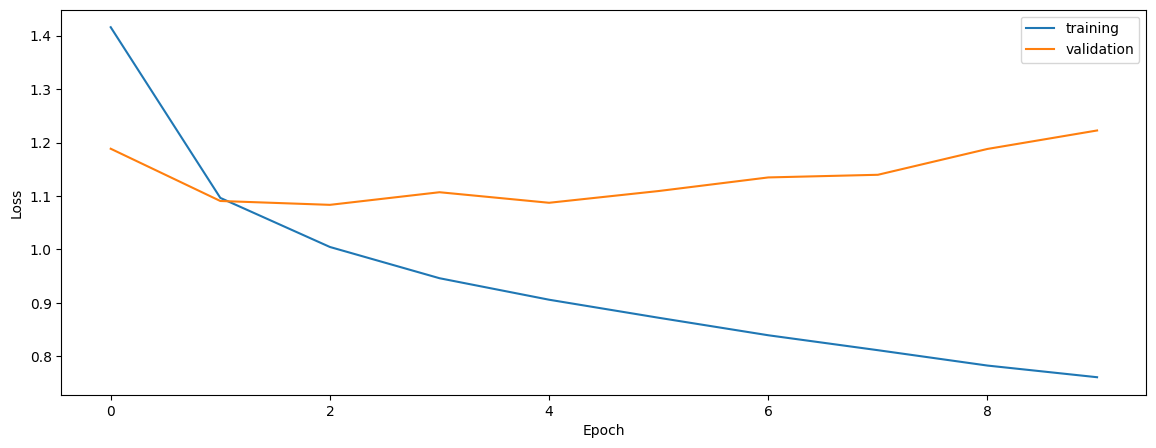

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['features'] = []
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

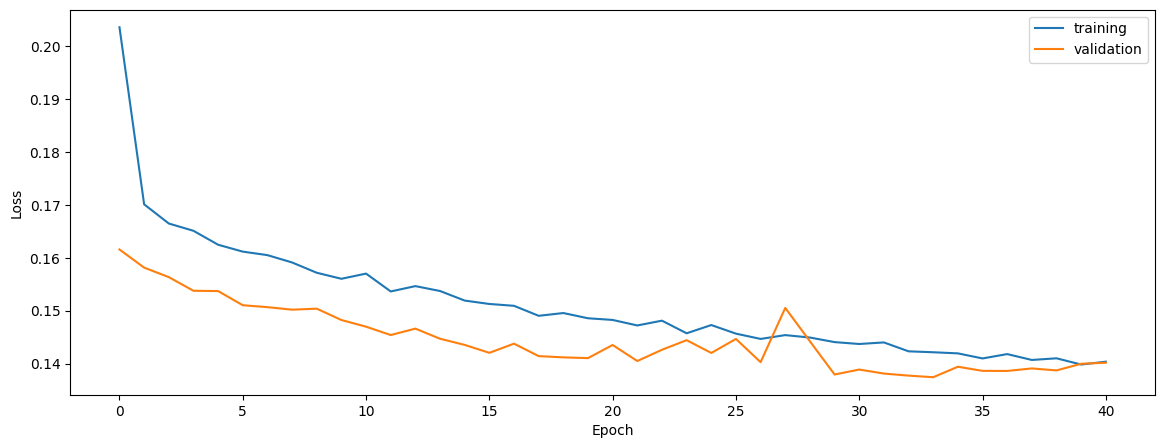

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.673905239942201
0.6731927710843374
0.6317241830635661


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6691299966409137
0.6666299922983827
0.6249763122986546


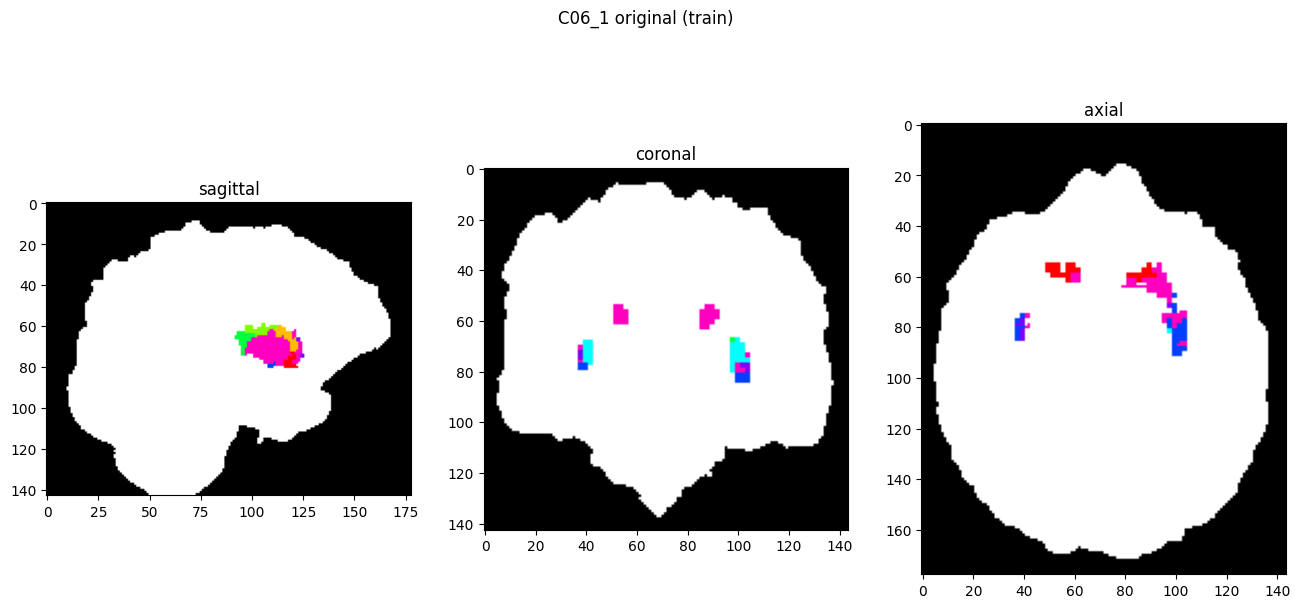

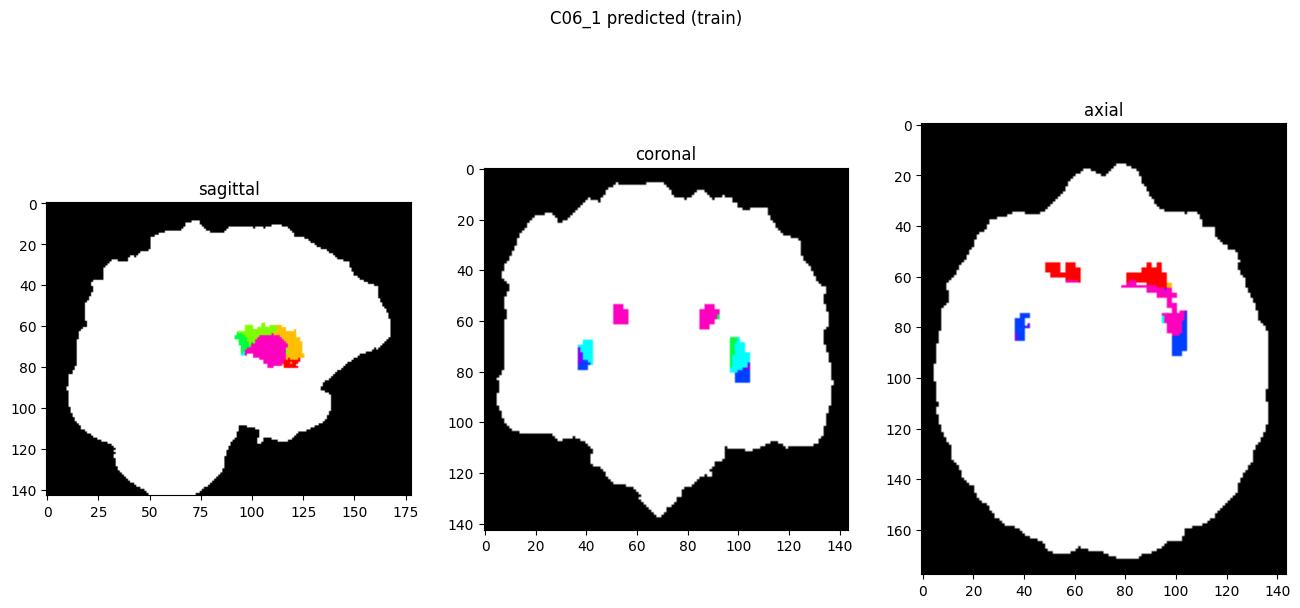

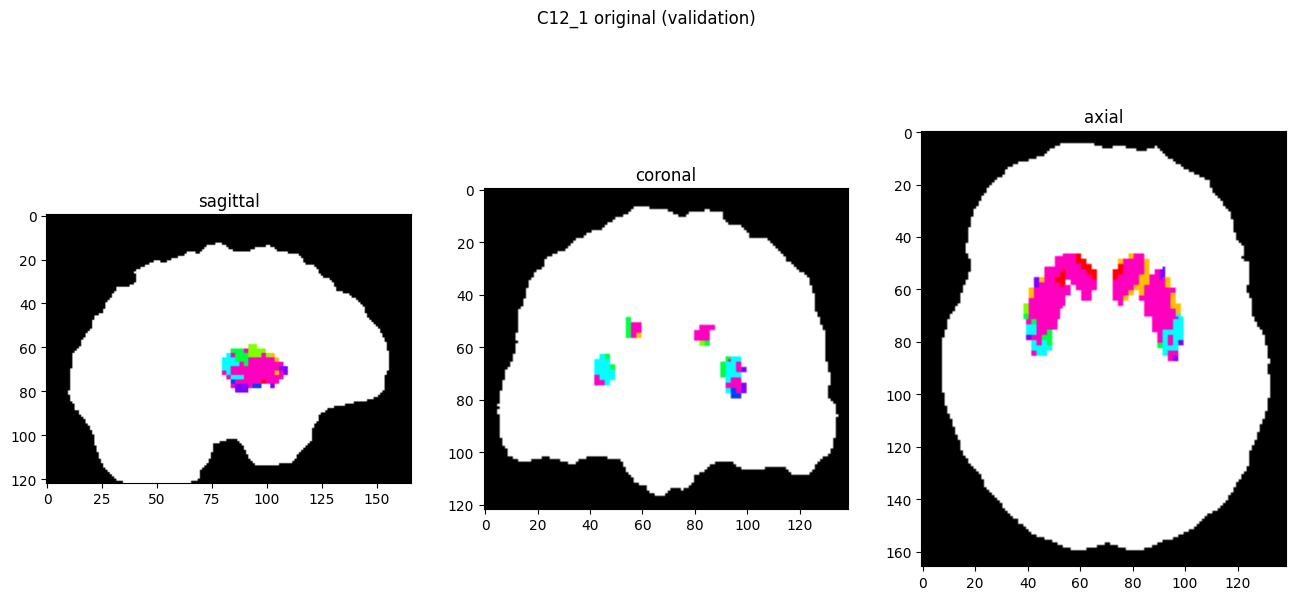

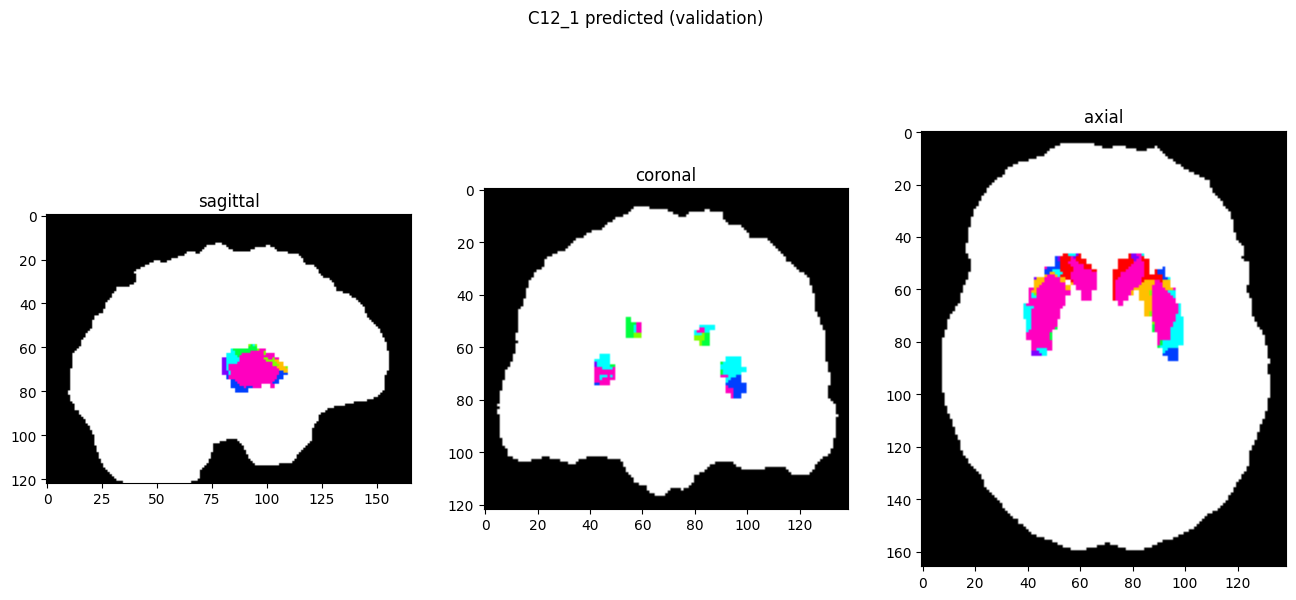

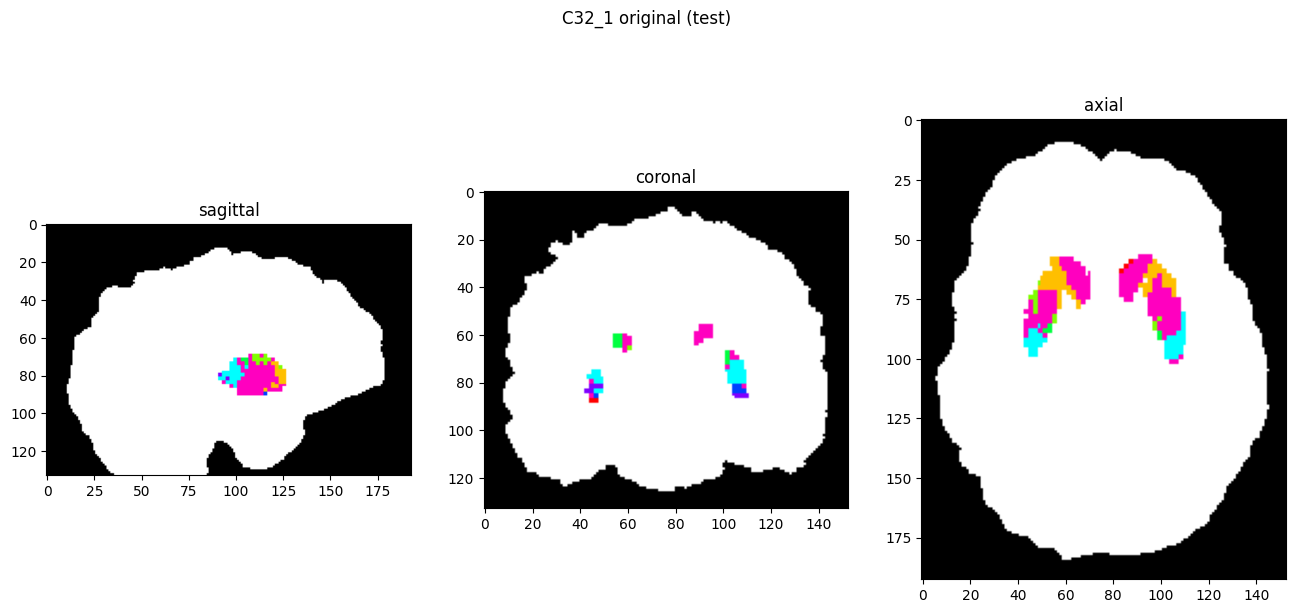

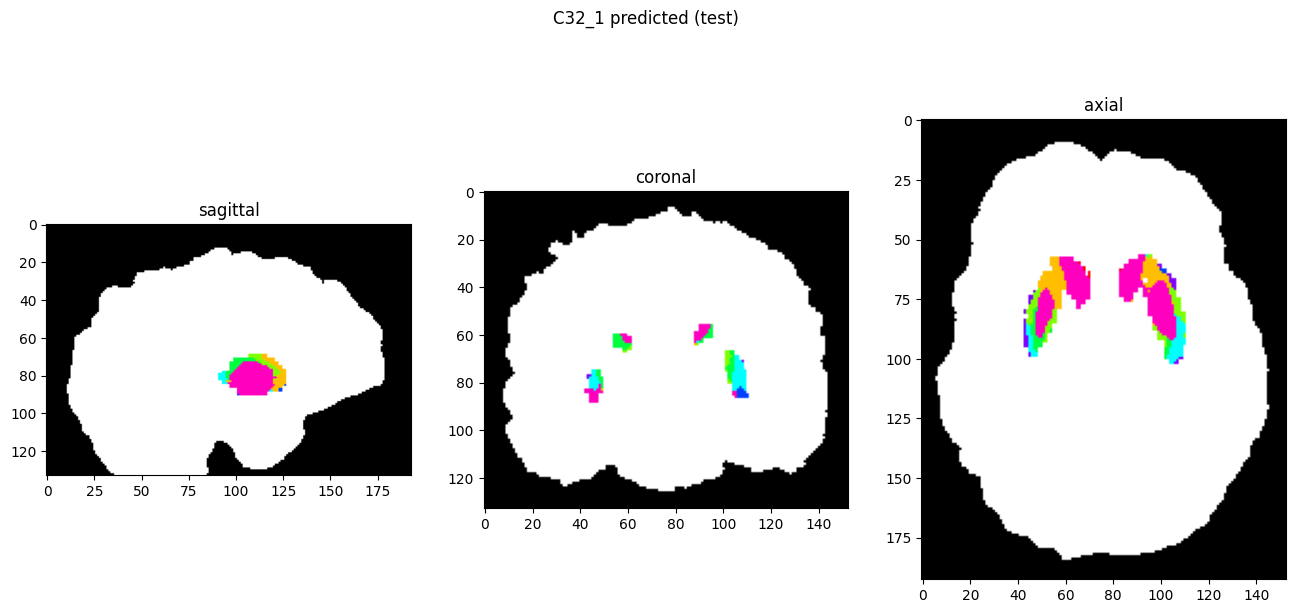

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)